

# 📘 Image Registration

## **🧩 1. Conceptual Explanation**

**What is image registration?**
Image registration is the process of aligning two or more images so that the parts that represent the same object (or scene) overlap correctly. This is important because when you take multiple pictures of the same subject (e.g., the brain, a face, or a landscape), differences can appear due to:

* Movement of the **camera**
* Movement of the **object**
* Changes in **zoom** (scaling)
* Changes in **orientation** (rotation)

Without registration, the images will not line up, making it difficult to compare or combine them.

**Example scenario:**

* You take two photos of a person. In one, the camera shifted slightly. In the other, the person tilted their head.
* When we try to overlay these photos, the faces won’t line up properly.
* To fix this, we need to transform one of the images (shift, scale, rotate, or even deform it) until it matches the other.

**Why do we care?**
In **neuroimaging** (and medical imaging in general), this is critical. For example:

* **Functional MRI (fMRI):** measures brain activity through blood-oxygenation signals (BOLD).
* **Anatomical MRI (T1-weighted):** shows brain structure (gray matter vs. white matter).

If the subject moves during scanning, the functional and anatomical images won’t align. Image registration ensures that the functional data can be accurately mapped onto the structural anatomy.

---

## Simple Example with Photos

we load two slightly shifted photos and try to visualize their differences by combining them into a “stereo image.”




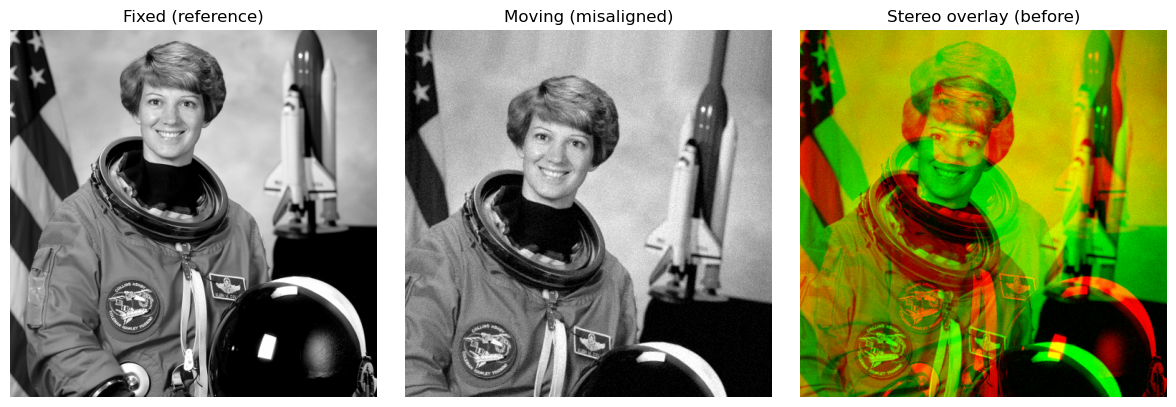

fixed shape: (512, 512) | moving shape: (512, 512) | dtype: float32


In [1]:
# ============================
# Set 1: make a toy 2D problem
# ============================
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, transform, util

# 1) Use a built-in natural image and convert to grayscale
img_rgb = data.astronaut()                         # (512, 512, 3), float in [0, 255] or [0, 1] depending on version
img = color.rgb2gray(img_rgb).astype(np.float32)   # -> (512, 512), float32 in [0,1]

# 2) Define a known transformation to "misalign" the moving image
#    We'll use a *similarity* transform: (scale + rotation + translation)
true_shift = (12.5, -8.0)   # (row, col) translation in pixel units (Δy, Δx)
true_angle = 8.0            # degrees rotation (positive = counter-clockwise)
true_scale = 1.07           # 7% zoom

# skimage's SimilarityTransform expects translation = (tx=Δx, ty=Δy)
tform_true = transform.SimilarityTransform(
    scale=true_scale,
    rotation=np.deg2rad(true_angle),
    translation=(true_shift[1], true_shift[0])
)

# 3) Warp the *fixed* image to create a *moving* (misaligned) version
#    - We apply the INVERSE of the true transform to simulate a real-world "moving" image.
#    - mode="edge" pads with edge values so the FOV stays pleasant at the borders.
moving = transform.warp(img, inverse_map=tform_true.inverse, mode="edge").astype(np.float32)

# (Optional) Add a tiny bit of noise to make the problem more realistic
rng = np.random.default_rng(0)
moving = util.random_noise(moving, mode='gaussian', var=0.001).astype(np.float32)

# 4) Expose variables with names used by the registration code
fixed = img   # reference image we want to align to
# moving already defined above

# 5) Quick look and an RGB "stereo" overlay to see the misalignment
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(fixed,  cmap='gray'); ax[0].set_title("Fixed (reference)");   ax[0].axis('off')
ax[1].imshow(moving, cmap='gray'); ax[1].set_title("Moving (misaligned)"); ax[1].axis('off')

stereo = np.zeros((*fixed.shape, 3), dtype=float)  # red=fixed, green=moving
stereo[..., 0] = fixed
stereo[..., 1] = moving
ax[2].imshow(np.clip(stereo, 0, 1)); ax[2].set_title("Stereo overlay (before)"); ax[2].axis('off')
plt.tight_layout(); plt.show()

print("fixed shape:", fixed.shape, "| moving shape:", moving.shape, "| dtype:", fixed.dtype)


👉 In the stereo image:

* Areas where the two photos match → **yellow** (red + green).
* Areas that differ → appear **red** or **green** only.

This shows **misalignment** clearly.

---

# **🧩 2.  Affine Registration & Optimization**

## 2.1. What is an Affine Transformation?

An **affine transformation** is a mathematical function that can move and reshape an image while preserving straight lines and parallelism.

It includes **global transformations** applied to the entire image:

* **Translation** → shifting up/down/left/right
* **Rotation** → clockwise or counterclockwise
* **Scaling** → zooming in or out
* **Shearing** → slanting/skewing rows or columns

👉 Affine transforms are good when **the whole object moved consistently** (like the head shifting a little in an MRI scanner).

---

## 2.2. Why Do We Need Optimization?

We usually **don’t know** the correct affine parameters ahead of time.
So the task is: *find the best transformation that aligns Image A with Image B.*

This is done through an **optimization process**:

1. **Start with initial parameters** (translation, rotation, scale, shear).

   * Sometimes we guess (`params0=None` means “start from scratch”).
2. **Apply the transformation** to the moving image.
3. **Measure the cost** → a function describing how “different” the two images are.

   * Examples: Mean Squared Error (MSE), Mutual Information (popular in multimodal MRI).
4. **Adjust the parameters** → change them slightly to reduce the cost.
5. **Iterate** until the cost is minimized (images overlap as much as possible).

➡️ This is just like teaching a model: **the optimizer searches parameter space until alignment is best.**

---

## 2.3. Multilevel / Multiresolution Optimization (Coarse→Fine)

## Intuition (why it works)

* Real images have structure at many scales. If you optimize at **full resolution** from scratch, the cost surface (SSD/CC/MI) can be **bumpy** with many local minima (edges, noise, texture).
* Build a **Gaussian pyramid**: heavily **blur + downsample** to get a coarse version (keep only large structures), then progressively increase resolution.
* At **coarse levels**, the cost surface is **smoother** (fewer local minima) and transforms have a **larger capture range**. You find a good approximate alignment.
* You then **propagate** those parameters down to **finer** levels and **refine** details.

In DIPY logs:

```
Optimizing level 2 [max iter: 10000]  # coarsest (most blurred/downsampled)
Optimizing level 1 [max iter: 1000]   # medium
Optimizing level 0 [max iter: 100]    # finest (original resolution)
```

This is controlled by three lists you pass to DIPY:

* `factors`: downsampling at each level (e.g., `[4, 2, 1]`)
* `sigmas`: Gaussian blur (in **voxels**) at each level (e.g., `[3.0, 1.0, 0.0]`)
* `level_iters`: max iterations per level (e.g., `[10000, 1000, 100]`)

---

## 2.4. How DIPY uses your schedules

* **Level 2** (coarse): blur with `sigma=3.0` voxels, downsample by `4×`, then run up to `10000` iterations.
* **Level 1**: blur `1.0`, downsample `2×`, run up to `1000` iters, **initialized by the level-2 result**.
* **Level 0** (fine): no blur, no downsampling, do a short refinement (`100` iters), **initialized by level-1**.

This chaining is what makes the approach robust and fast.

---

## 2.5. Practical tips (rules of thumb)

* Start with something like
  `factors=[4,2,1]`, `sigmas=[3,1,0]`, `level_iters=[10000,1000,100]` for 2D;
  for 3D, reduce iters if needed (memory/time).
* Larger **factors** and **sigmas** → smoother, safer capture at the top but slower overall.
* If alignment fails:
  increase top-level `sigma`, add an even coarser level (e.g., `factors=[8,4,2,1]`, `sigmas=[4,2,1,0]`), increase `level_iters` at coarse levels.
* If it’s **too slow**: lower `level_iters`, or downsample data outside DIPY first.

---

---

## 2.6. Example with DIPY

Below is a working example using DIPY’s `AffineRegistration`.
We’ll use a built-in `scikit-image` example image and create a *misaligned* version of it (so you can run this without special data).

### 🔧 Affine Optimization with DIPY

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


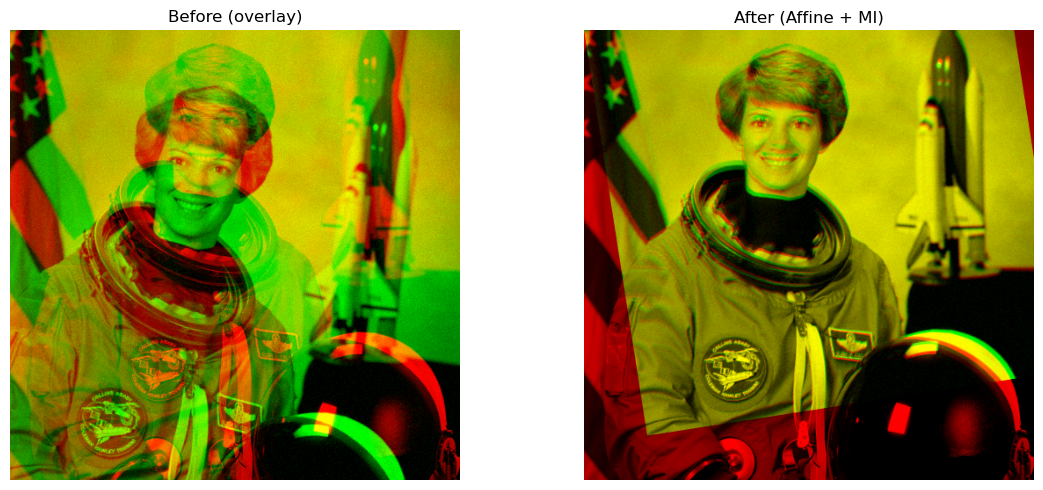

Estimated affine (2D):
 [[ 1.08341589e+00  1.67833514e-01  8.32312666e-04]
 [-1.63301344e-01  1.04632190e+00 -1.11271445e-03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean |fixed - moving| before: 0.2458
Mean |fixed - registered| after: 0.1180


In [2]:
# ===========================================
# Set 2: 2D affine registration with DIPY (MI)
# ===========================================
import numpy as np
import matplotlib.pyplot as plt

# (Assumes Set 1 was run, so `fixed` and `moving` exist.)
# Safety: ensure float32 and values in [0,1]
fixed  = np.clip(fixed.astype(np.float32),  0, 1)
moving = np.clip(moving.astype(np.float32), 0, 1)

# --- Visualize initial overlay ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ov_before = np.dstack([fixed, moving, np.zeros_like(fixed)])  # R=fixed, G=moving
ax[0].imshow(ov_before); ax[0].set_title("Before (overlay)"); ax[0].axis("off")

# --- DIPY affine registration with Mutual Information ---
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import AffineTransform2D

# Multiresolution (image pyramid) parameters: coarse -> fine
level_iters = [10000, 1000, 100]   # iterations per level
sigmas      = [3.0,   1.0,  0.0]   # Gaussian smoothing (in voxels) at each level
factors     = [4,     2,    1]     # downsampling factor per level

# Similarity metric:
# - MI (Mutual Information) is robust to intensity differences between images.
metric  = MutualInformationMetric(nbins=32)

# Registration object
affreg  = AffineRegistration(metric=metric,
                             level_iters=level_iters,
                             sigmas=sigmas,
                             factors=factors)

# Transform model:
# - Full 2D affine (translation + rotation + scale + shear)
transform_model = AffineTransform2D()

# Optimize affine that maps moving -> fixed.
# NOTE: For 2D toy images with identity voxel-to-world mapping,
#       we can omit static_grid2world/moving_grid2world (defaults to identity).
affine_map = affreg.optimize(
    static=fixed,
    moving=moving,
    transform=transform_model,
    params0=None  # no prior transform
)

# Apply the estimated affine to the moving image
registered = affine_map.transform(moving)

# --- Visualize result (overlay after registration) ---
ov_after = np.dstack([fixed, registered, np.zeros_like(fixed)])  # R=fixed, G=registered
ax[1].imshow(ov_after); ax[1].set_title("After (Affine + MI)"); ax[1].axis("off")
plt.tight_layout(); plt.show()

# --- Inspect the 3x3 affine matrix (2D homogeneous coords) ---
print("Estimated affine (2D):\n", affine_map.affine)

# (Optional) Quantify improvement by mean absolute difference in overlap
before_err = np.mean(np.abs(fixed - moving))
after_err  = np.mean(np.abs(fixed - registered))
print(f"Mean |fixed - moving| before: {before_err:.4f}")
print(f"Mean |fixed - registered| after: {after_err:.4f}")




## 2.7. Key Takeaways

* **Affine registration** handles global alignment: translation, rotation, scaling, shearing.
* **Optimization** searches parameter space to minimize a cost function.
* **Multilevel strategy** → register at low → medium → high resolutions for robustness.
* Works well if subject/camera just moved slightly.
* **Limitations**: Cannot handle *non-rigid deformations* (like facial expressions, organ bending). For that, we need **nonlinear registration**.

---




# **📐 3. Mathematical Optimization in Image Registration**

## 3.1. The core problem

We want parameters **θ** of a transformation **T** that make a **moving** image *M* look like a **fixed** image *F*.

$$
\hat{\theta}=\arg\min_{\theta}\; \mathcal{C}\!\left(F,\;T(M;\theta)\right)
$$

* **F**: fixed/reference image
* **M**: moving image (to be transformed)
* **T(M;θ)**: M after applying the transform with parameters θ
* **𝒞**: cost (dissimilarity) between F and the transformed M

**Optimization loop (conceptually):**

1. choose an initial θ₀ → 2) transform M → 3) compute 𝒞 → 4) update θ to reduce 𝒞 → 5) stop when changes are small or a limit is reached.

---

## 3.2. What goes into the objective

Most practical objectives combine **data fit** and **regularization**:

$$
\hat{\theta}=\arg\min_{\theta}\; \underbrace{\mathcal{C}\!\left(F,T(M;\theta)\right)}_{\text{match F and M}} \;+\; \lambda\,\underbrace{\mathcal{R}(\theta)}_{\text{stability/constraints}}
$$

* **Data term 𝒞** (choose based on image contrast):

  * **SSD** (sum of squared differences): $\sum (F - T(M;θ))^2$. Works when intensities are comparable (mono-modal).
  * **NCC** (normalized cross-correlation): robust to linear intensity changes (mono-modal).
  * **CC** (local/cross-correlation): compares local windows; standard for T1↔T1 nonlinear.
  * **MI** (mutual information): handles very different contrasts (multi-modal).
* **Regularizer 𝑹** (especially for nonlinear warps):

  * penalizes excessive bending, stretching, or roughness (e.g., bending energy, diffusion/smoothness).
  * in diffeomorphic methods, regularization is implicit via the velocity-field norm and smoothing.
* **Masks / weights**:

  * limit the comparison to brain (exclude skull/air); or weight important regions more.

---

## 3.3. Transformation models (what θ means)

* **Rigid (6 DOF 3D / 3 DOF 2D):** translations + rotations. Conserves shape/size.
* **Affine (12 DOF 3D / 6 DOF 2D):** rigid + uniform/anisotropic scaling + shear. Global shape changes only.
* **Nonlinear (deformation fields):** spatially varying displacements for local alignment:

  * **B-spline FFD:** control-point grid; flexible but not inherently topology-preserving.
  * **Diffeomorphic (e.g., SyN, LDDMM):** optimize a smooth velocity field and exponentiate it → **invertible, topology-preserving** warp.

**Parameterization tips:** use robust rotation representations (quaternions/Euler with care); keep scales/shears well-conditioned.

---

## 3.4. Interpolation & resampling (how we evaluate 𝒞)

* The moving image must be **sampled at non-integer locations** after transformation.
* Common interpolators: nearest (fast, blocky), linear (standard), cubic (smoother).
* Interpolation introduces smoothing; minimize unnecessary reslices by composing transforms and resampling **once** when possible.

---

## 3.5. Optimizers (how θ gets updated)

* **Derivative-free:** Powell, Nelder–Mead — robust for small parameter counts (rigid/affine).
* **Gradient-based:** Gauss-Newton/Levenberg–Marquardt, (L-)BFGS, gradient descent — common when gradients of 𝒞 are available/estimated.
* **Line search / step length:** controls how far each parameter update moves.
* **Stochastic/partial sampling:** evaluate 𝒞 on subsets of voxels for speed; update over batches.

**Convergence checks:** small change in cost, small change in θ, or max iterations/pyramid level reached.

---

## 3.6. Multi-resolution (image pyramids)

To avoid local minima and speed things up:

1. blur & downsample both images (coarse level) → align large structures
2. move to finer levels with less blur → refine details
   Choose per-level **iterations**, **smoothing sigmas**, and **downsampling factors**.

---

## 3.7. Initialization (starting θ matters)

* **Center of mass / moments** alignment.
* **Landmarks / fiducials** if available.
* **Rigid → affine → nonlinear** staged strategy.
* For diffeomorphic methods, a good affine **pre-align** is especially important.

---

## 3.8. Special note on diffeomorphic registration (e.g., **SyN**)

* **Goal:** estimate a **smooth, invertible** mapping with positive Jacobian (no folds).
* **How:** optimize a **stationary velocity field**; exponentiate it (scaling-and-squaring) to get the warp.
* **Symmetry:** SyN optimizes both directions (moving→fixed and fixed→moving), reducing bias toward either image.
* **Metric:** local **cross-correlation (CC)** is typical for same-contrast anatomy.
* **Regularization:** controls field smoothness; prevents unrealistic expansions/compressions.
* **Outputs:** forward and inverse warps; you can apply the same transform chain to other images (EPI, masks) to keep them consistent.

**Why diffeomorphic vs. affine?**
Affine matches global pose/size; diffeomorphic adds **local** alignment without tearing the image, enabling voxel-wise group analyses in a common space.

---

## 3.9. Quality control & validation

* **Visual overlays:** red/green blends, side-by-side slices, or fused views.
* **Landmark/contour error:** measure target registration error (TRE) if points/labels exist.
* **Jacobian determinant (nonlinear):** check for positivity and reasonable range (no folds, no extreme expansions).
* **Similarity curves:** ensure 𝒞 decreases and stabilizes across iterations/levels.

---

## 3.10. Practical pitfalls & remedies

* **Poor pre-alignment:** start with rigid/affine; consider center-of-mass.
* **Background/skull influence:** use **brain masks** for metric evaluation.
* **Bias field / intensity drift:** consider **N4 bias correction** or histogram normalization.
* **Too flexible warps (overfitting):** strengthen regularization, reduce iterations/step length, enlarge CC window slightly.
* **Interpolation blur from repeated reslices:** compose transforms, resample once at the end.

---

## 3.11. Transform composition & consistent application

* Keep a **transform chain** (e.g., native→T1, T1→MNI). Compose mathematically; apply once when resampling to avoid cumulative blur.
* Apply the **same composed transform** to all derived data (EPI, masks, parcellations) to maintain alignment.

---

### Summary

Registration is an optimization that balances **data similarity** and **regularization** over a chosen **transform model**.

* Use **rigid/affine** for global alignment,
* then **diffeomorphic (SyN)** for smooth, invertible local refinement,
* with **multi-resolution**, good **initialization**, appropriate **metrics** (MI/CC), and consistent **QC**.


---



# **🧩  4. Common Cost Functions:**

##  4.1 Sum of Squared Differences (SSD)

**What it measures.**
SSD sums the squared intensity differences at corresponding locations after the moving image is transformed:

$$
\mathcal{C}_{\text{SSD}}(F,M)=\sum_{x}\big(F(x)-M(x)\big)^2
$$

* **Lower is better** (0 means perfect match).
* Equivalent to $N \times \text{MSE}$ (just differs by a constant factor), so minimizing either is the same.

**When SSD shines.**

* **Same modality & contrast** (e.g., T1 vs T1, same sequence/protocol).
* Images have **comparable intensity scaling** (no big gain/offset differences).

**Pros.**

* Simple, fast, smooth objective → works well with gradient-based optimizers.
* Strong signal when intensities truly correspond voxel-wise.

**Cons (and quick fixes).**

* **Sensitive to intensity scaling/offset**
  → Normalize intensities first (e.g., scale to $[0,1]$ or z-score within a brain mask).
* **Sensitive to bias field / inhomogeneity**
  → Do light bias-field correction (e.g., N4) or at least histogram normalization.
* **Background/skull can dominate**
  → Use a **mask** (brain only) for the cost.
* **Outliers influence** (squared errors amplify them)
  → For robustness, some pipelines use Huber/Tukey losses, but plain SSD is fine for learning and clean data.

**Practical tips before optimizing with SSD.**

1. Clip/scale both images to a common range (or z-score in brain).
2. If available, apply masks for the cost evaluation.
3. Use a multi-resolution pyramid (coarse→fine) to capture big moves first.
4. Start with rigid/affine, then consider nonlinear if needed.



  

**Notes**

* If you see SSD not decreasing much, normalize intensities a bit more strictly (e.g., z-score each image), or mask out the background during optimization.
* For multi-modal pairs (e.g., T1 vs T2), **don’t** use SSD—switch back to **Mutual Information**.


Method: SSD minimization (Powell) + scikit-image warp
Estimated affine (2D, homogeneous 3×3):
 [[  0.926464     0.13089192   5.35277755]
 [ -0.12948889   0.92626791 -13.02312195]
 [  0.           0.           1.        ]]
SSD before: 30675.1113
SSD after : 4835.8022


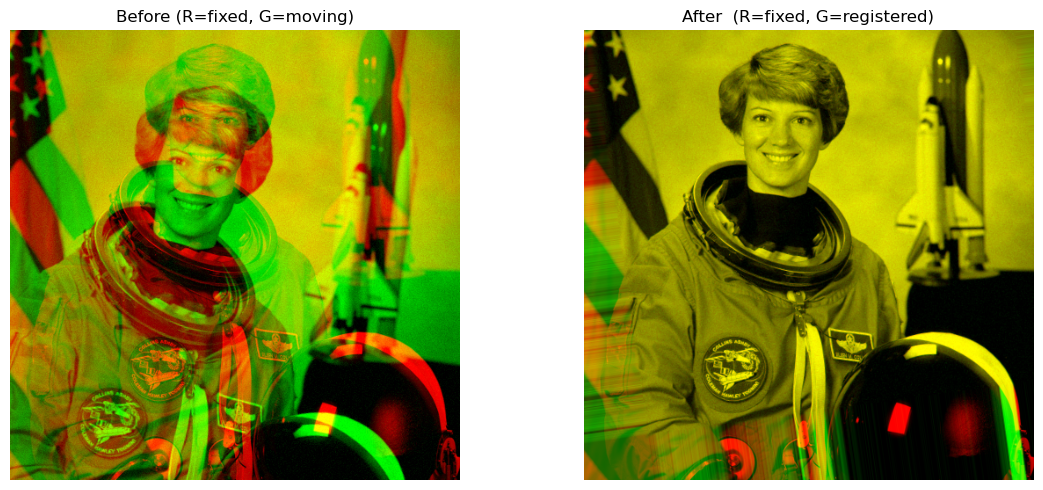

In [3]:
# ============================================
# Simple 2D affine registration using SSD
# (scikit-image + SciPy, minimal version)
# Assumes:
#   - fixed, moving : 2D NumPy arrays, same shape
# ============================================
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp, resize
from scipy.optimize import minimize

# 0) Prepare images: float32, normalized to [0, 1]
fixed  = fixed.astype(np.float32)
moving = moving.astype(np.float32)

def minmax(a):
    a_min, a_max = float(a.min()), float(a.max())
    if a_max <= a_min + 1e-8:
        return np.zeros_like(a, dtype=np.float32)
    return (a - a_min) / (a_max - a_min)

F_full = minmax(fixed)
M_full = minmax(moving)

# 1) SSD metric (sum of squared differences) – lower is better
def ssd(A, B):
    D = A.astype(np.float32) - B.astype(np.float32)
    return float(np.sum(D * D))

# 2) Affine parametrization
# p = [tx, ty, theta_deg, scale, shear_deg]
#    tx, ty      : translation (pixels)
#    theta_deg   : rotation (degrees)
#    scale       : zoom
#    shear_deg   : shear (degrees)
def build_affine_matrix(p, center):
    tx, ty, theta_deg, s, shear_deg = p
    theta = np.deg2rad(theta_deg)
    shear = np.deg2rad(shear_deg)
    cx, cy = center  # (x, y)

    # Centering transforms
    T_c_inv = np.array([[1, 0, -cx],
                        [0, 1, -cy],
                        [0, 0,  1 ]], dtype=np.float64)
    T_c     = np.array([[1, 0,  cx],
                        [0, 1,  cy],
                        [0, 0,  1 ]], dtype=np.float64)

    # Rotation, scale, shear
    R  = np.array([[ np.cos(theta), -np.sin(theta), 0],
                   [ np.sin(theta),  np.cos(theta), 0],
                   [ 0,              0,             1]], dtype=np.float64)
    S  = np.array([[s, 0, 0],
                   [0, s, 0],
                   [0, 0, 1]], dtype=np.float64)
    Sh = np.array([[1, np.tan(shear), 0],
                   [0, 1,             0],
                   [0, 0,             1]], dtype=np.float64)

    # Final translation
    T_t = np.array([[1, 0, tx],
                    [0, 1, ty],
                    [0, 0,  1]], dtype=np.float64)

    # Full affine: center → R*S*Sh → uncenter → translate
    A = T_t @ T_c @ R @ S @ Sh @ T_c_inv
    return A

def warp_with_params(p, img, center, order=1):
    """Warp img with affine defined by p (tx,ty,theta,scale,shear)."""
    A = build_affine_matrix(p, center)
    tform = AffineTransform(matrix=A)
    out = warp(
        img,
        inverse_map=tform.inverse,  # inverse-map warping
        order=order,                # 1 = bilinear
        mode="edge",
        preserve_range=True
    )
    return out.astype(np.float32), A

# 3) Multi-resolution optimization (coarse → fine)
scales = [0.5, 1.0]                      # downsample factors
p = np.array([0, 0, 0, 1, 0], float)     # initial guess (identity-like)

for i, s in enumerate(scales):
    # Resize images for current scale
    if s != 1.0:
        out_shape = (
            int(round(F_full.shape[0] * s)),
            int(round(F_full.shape[1] * s))
        )
        F = resize(F_full, out_shape, anti_aliasing=True,
                   preserve_range=True).astype(np.float32)
        M = resize(M_full, out_shape, anti_aliasing=True,
                   preserve_range=True).astype(np.float32)
    else:
        F, M = F_full, M_full

    H, W = F.shape
    center = (W / 2.0, H / 2.0)  # (x, y)

    # Scale translations from previous level to this resolution
    if i > 0:
        prev_s = scales[i - 1]
        factor = s / prev_s
        p[0] *= factor  # tx
        p[1] *= factor  # ty

    # Objective: SSD between fixed and warped moving
    def obj(q):
        warped, _ = warp_with_params(q, M, center, order=1)
        return ssd(F, warped)

    # Powell optimizer (no gradients needed)
    res = minimize(
        obj, p, method="Powell",
        options={"maxiter": 200, "xtol": 1e-3, "ftol": 1e-4, "disp": False}
    )
    p = res.x  # carry solution to next (finer) level

# 4) Final warp at full resolution
center_full = (F_full.shape[1] / 2.0, F_full.shape[0] / 2.0)
registered, A_final = warp_with_params(p, M_full, center=center_full, order=1)

# 5) Report and visualize
ssd_before = ssd(F_full, M_full)
ssd_after  = ssd(F_full, registered)

print("Method: SSD minimization (Powell) + scikit-image warp")
print("Estimated affine (2D, homogeneous 3×3):\n", A_final)
print(f"SSD before: {ssd_before:.4f}")
print(f"SSD after : {ssd_after:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ov_before = np.dstack([F_full, M_full,     np.zeros_like(F_full)])
ov_after  = np.dstack([F_full, registered, np.zeros_like(F_full)])

ax[0].imshow(ov_before); ax[0].set_title("Before (R=fixed, G=moving)");     ax[0].axis("off")
ax[1].imshow(ov_after);  ax[1].set_title("After  (R=fixed, G=registered)"); ax[1].axis("off")

plt.tight_layout()
plt.show()




## 4.2. Cross-Correlation (CC)

**What it measures.**
CC measures how strongly two images co-vary after alignment. It’s the (negative) Pearson correlation between the fixed image $F$ and the transformed moving image $M$:

$$
\mathcal{C}_{\text{CC}}(F,M) \;=\; -\,\frac{\sum_x (F(x)-\bar F)\,(M(x)-\bar M)}{\sqrt{\sum_x(F(x)-\bar F)^2}\;\sqrt{\sum_x(M(x)-\bar M)^2}}
$$

* **Range:** $[-1,1]$ for the correlation $r$; we often **minimize** $-r$ or **maximize** $r$.
* **Interpretation:** $+1$ = perfect linear match; $0$ = no linear relation; $-1$ = perfect inverse.
* **When to use:** **Same-modality** (e.g., T1↔T1) when intensities are linearly related (possibly different gain/offset).
* **Why it’s nice:** Invariant to global scaling and offset (unlike SSD), so it’s robust to intensity rescaling when contrast is the same.
* **Local CC:** Nonlinear methods (e.g., SyN) typically use **local** CC over small windows to capture local similarities while remaining robust to intensity drifts.



### 🧪 Affine registration using CC 



Method used: SciPy + scikit-image (CC maximization, Powell)
Estimated affine (2D, homogeneous 3×3):
 [[  0.92655088   0.13084356   5.32507999]
 [ -0.12926033   0.92633001 -13.09783105]
 [  0.           0.           1.        ]]
Global CC before: 0.3198
Global CC after : 0.8909


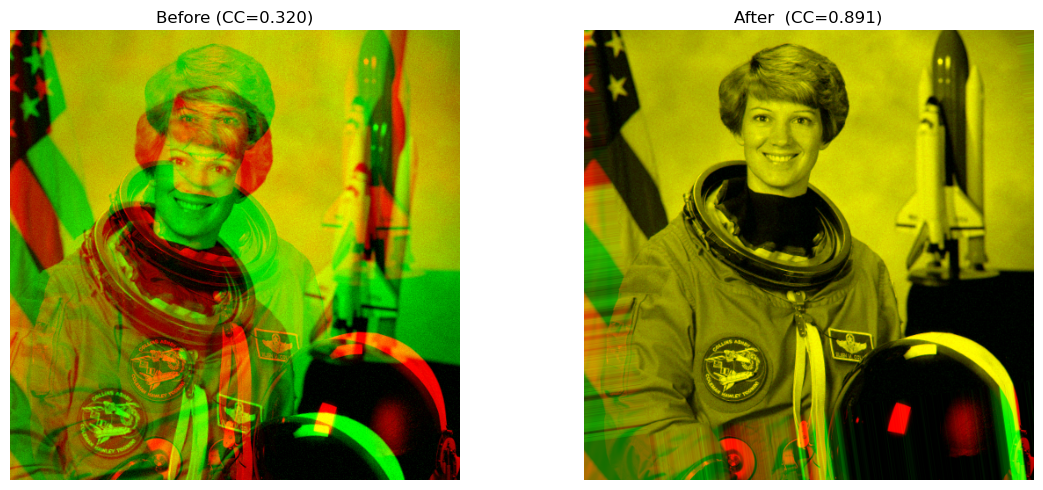

In [31]:
# ===========================================================
# 2D affine registration using Cross-Correlation (CC)
# Libraries: NumPy, scikit-image, SciPy
# Inputs expected in memory: fixed (H×W), moving (H×W)  [float or convertible]
# Optional in memory: mask (H×W boolean) to restrict the metric to ROI
# ===========================================================
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import AffineTransform, warp, resize
from scipy.optimize import minimize

# -----------------------------
# 0) Prep images
# -----------------------------
fixed  = np.asarray(fixed,  dtype=np.float32)
moving = np.asarray(moving, dtype=np.float32)

# Normalize to [0,1] for stable metrics/visuals (keeps relative contrast)
def _minmax(a):
    a_min, a_max = float(a.min()), float(a.max())
    if a_max <= a_min + 1e-8:
        return np.zeros_like(a, dtype=np.float32)
    return (a - a_min) / (a_max - a_min)

F_full = _minmax(fixed)
M_full = _minmax(moving)

# Optional mask from globals (e.g., brain mask). Must match image shape.
mask = globals().get("mask", None)
if mask is not None:
    mask = np.asarray(mask, dtype=bool)
    if mask.shape != F_full.shape:
        raise ValueError(f"mask shape {mask.shape} must match image shape {F_full.shape}")

# -----------------------------
# 1) Metric: global Pearson CC
# -----------------------------
def cc_score(A, B, mask=None):
    """ Pearson correlation in [-1,1]. Higher is better. """
    if mask is not None:
        A = A[mask]
        B = B[mask]
    A = A.astype(np.float32) - float(A.mean())
    B = B.astype(np.float32) - float(B.mean())
    denom = (np.sqrt((A*A).sum()) * np.sqrt((B*B).sum())) + 1e-12
    return float((A*B).sum() / denom)

# -----------------------------
# 2) Parametrization
# p = [tx, ty, theta_deg, scale, shear_deg]
# - Translation (pixels), rotation about image center, uniform scale, shear.
# -----------------------------
def build_affine_matrix(p, center):
    """Return 3x3 matrix for (tx,ty,theta,scale,shear) about image center."""
    tx, ty, theta_deg, s, shear_deg = p
    theta = np.deg2rad(theta_deg)
    shear = np.deg2rad(shear_deg)
    cx, cy = center  # (x, y) pixel coords

    # Transforms as 3x3 matrices
    T_c_inv = np.array([[1, 0, -cx],
                        [0, 1, -cy],
                        [0, 0,   1 ]], dtype=np.float64)

    R = np.array([[ np.cos(theta), -np.sin(theta), 0],
                  [ np.sin(theta),  np.cos(theta), 0],
                  [ 0,              0,             1]], dtype=np.float64)

    S = np.array([[s, 0, 0],
                  [0, s, 0],
                  [0, 0, 1]], dtype=np.float64)

    Sh = np.array([[1, np.tan(shear), 0],
                   [0, 1,             0],
                   [0, 0,             1]], dtype=np.float64)

    T_c = np.array([[1, 0, cx],
                    [0, 1, cy],
                    [0, 0, 1 ]], dtype=np.float64)

    T_t = np.array([[1, 0, tx],
                    [0, 1, ty],
                    [0, 0, 1 ]], dtype=np.float64)

    # Order: translate -> (center^-1 -> shear -> scale -> rotate -> center)
    # Then global translation T_t at the end.
    A = T_t @ T_c @ R @ S @ Sh @ T_c_inv
    return A

def warp_with_params(p, img, center, order=1):
    """Warp img with affine defined by p (tx,ty,theta,scale,shear) about center."""
    A = build_affine_matrix(p, center)
    tform = AffineTransform(matrix=A)
    out = warp(img, inverse_map=tform.inverse,
               order=order, mode="edge", preserve_range=True)
    return out.astype(np.float32), A

# -----------------------------
# 3) Multi-resolution pyramid
# -----------------------------
# Coarse -> fine scales (fractions of original size)
scales = [0.5, 1.0]  # add 0.25 for extra robustness if needed
p = np.array([0.0, 0.0, 0.0, 1.0, 0.0], dtype=float)  # initial guess

for i, s in enumerate(scales):
    # Resize images (and mask) to current scale
    if s != 1.0:
        out_shape = (int(round(F_full.shape[0]*s)), int(round(F_full.shape[1]*s)))
        F = resize(F_full, out_shape, anti_aliasing=True, preserve_range=True).astype(np.float32)
        M = resize(M_full, out_shape, anti_aliasing=True, preserve_range=True).astype(np.float32)
        mask_s = None
        if mask is not None:
            mask_s = resize(mask.astype(np.float32), out_shape, order=0, preserve_range=True).astype(bool)
    else:
        F, M, mask_s = F_full, M_full, mask

    H, W = F.shape
    center = (W/2.0, H/2.0)  # (x, y)

    # Scale translation params from previous level to current resolution
    if i > 0:
        prev_s = scales[i-1]
        factor = s / prev_s
        p[0] *= factor  # tx
        p[1] *= factor  # ty
        # rotation/scale/shear unchanged by image size

    # Objective: minimize NEGATIVE CC (i.e., maximize CC)
    def neg_cc_obj(q):
        warped, _ = warp_with_params(q, M, center)
        return -cc_score(F, warped, mask=mask_s)

    # Use Powell (derivative-free), robust for small parameter counts
    res = minimize(neg_cc_obj, p, method="Powell",
                   options={"maxiter": 200, "xtol": 1e-3, "ftol": 1e-4, "disp": False})
    p = res.x  # carry solution to next (finer) level

# -----------------------------
# 4) Final warp on full resolution
# -----------------------------
registered, A_final = warp_with_params(p, M_full, center=(F_full.shape[1]/2.0, F_full.shape[0]/2.0))

# -----------------------------
# 5) Report & visualize
# -----------------------------
cc_before = cc_score(F_full, M_full, mask=mask)
cc_after  = cc_score(F_full, registered, mask=mask)
print("Method used: SciPy + scikit-image (CC maximization, Powell)")
print("Estimated affine (2D, homogeneous 3×3):\n", A_final)
print(f"Global CC before: {cc_before:.4f}")
print(f"Global CC after : {cc_after:.4f}")

# Overlays (R=fixed, G=moving/registered)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ov_before = np.dstack([F_full, M_full,     np.zeros_like(F_full)])
ov_after  = np.dstack([F_full, registered, np.zeros_like(F_full)])
ax[0].imshow(ov_before); ax[0].set_title(f"Before (CC={cc_before:.3f})"); ax[0].axis("off")
ax[1].imshow(ov_after);  ax[1].set_title(f"After  (CC={cc_after:.3f})");  ax[1].axis("off")
plt.tight_layout(); plt.show()




## 4.3. Mutual Information (MI)

**4.3.1. What MI measures (intuition).**
Imagine stacking the two images’ intensities into a 2D table (a **joint histogram**): rows are gray levels in the fixed image $F$, columns are gray levels in the moving image $M$.

* If the images are **well aligned**, certain intensity pairs co-occur **consistently** (the joint histogram is concentrated), meaning **knowing $F$** tells you a lot about **$M$**.
* If they’re misaligned (or unrelated), co-occurrences are spread out (the joint histogram is diffuse).
  **MI** quantifies *how much* knowing one image reduces uncertainty about the other.

$$
\boxed{\;MI(F,M)=H(F)+H(M)-H(F,M)\;}
$$

Where

* $H(F) = -\sum_f p_F(f)\,\log p_F(f)$ is the **entropy** (uncertainty) of $F$,
* $H(M)$ is the entropy of $M$,
* $H(F,M) = -\sum_{f,m} p_{F,M}(f,m)\,\log p_{F,M}(f,m)$ is the **joint** entropy,
* $p_F, p_M, p_{F,M}$ are (joint) probability distributions of intensities.

**Key takeaways**

* **Higher MI ⇒ better alignment.** (We typically **maximize** MI, or **minimize** $-$MI.)
* **Modality-agnostic.** Even if intensities don’t match linearly (e.g., T1 vs T2, MRI vs CT), correct alignment creates **statistical dependence** that MI detects.
* **Robust to global intensity remappings** (e.g., gain/offset), unlike SSD. (In perfect math, MI is invariant under invertible remaps of each variable; in practice, histogram estimation makes this approximate but still robust.)

---

## 4.3.2. How MI is computed in practice (what the optimizer actually does)

1. **Sample corresponding voxels/pixels.**
   Often downsampled or randomly sampled for speed.

2. **Build a joint histogram** $H$ of $(F(x), M_\theta(x))$ pairs (after transforming $M$ by parameters $\theta$).

   * Choose **number of bins** (e.g., 32–64 for 8/12-bit images; 64–128 for 16-bit).
   * Optionally **clip** extreme intensities to reduce outlier influence.

3. **Smooth the histogram** with **Parzen windows** (e.g., B-spline kernels).

   * This makes the probability estimates **continuous and differentiable**, so gradient-based optimizers can be used.
   * Also reduces sampling noise and interpolation artifacts.

4. **Convert counts to probabilities** $p_{F,M}(f,m)=H(f,m)/\sum H$.
   Then get marginals $p_F(f)=\sum_m p_{F,M}(f,m)$ and $p_M(m)=\sum_f p_{F,M}(f,m)$.

5. **Compute entropies** $H(F), H(M), H(F,M)$ and **MI**.
   (Log base doesn’t matter for optimization; it just rescales MI.)

6. **Optimize transform parameters** $\theta$ to **maximize MI**.

   * Multiresolution pyramid (coarse→fine).
   * Line search / gradient-based updates (thanks to Parzen smoothing).
   * Stop when MI stabilizes or max iterations reached.

> In many toolkits (ITK/ANTs/DIPY), the “Mattes MI” implementation follows this recipe.

---

## 4.3.3. Normalized MI and related variants

* **Normalized Mutual Information (NMI)** reduces sensitivity to field-of-view/overlap changes. Two common definitions (be mindful which your library uses):

  * $\displaystyle \text{NMI}_1 = \frac{H(F)+H(M)}{H(F,M)}$
  * $\displaystyle \text{NMI}_2 = \frac{2\,MI(F,M)}{H(F)+H(M)}$
* **Entropy Correlation Coefficient (ECC)** and **symmetric uncertainty** are closely related.
  These all aim to stabilize the objective when the **overlap region changes** during optimization (e.g., due to large translations/rotations).

---

## 4.3.4. When to choose MI (vs. SSD or CC)

| Situation                                            | Best first choice                                 | Why                                                                         |
| ---------------------------------------------------- | ------------------------------------------------- | --------------------------------------------------------------------------- |
| **Multimodal** (MRI T1 vs T2, MRI vs CT, PET vs MRI) | **MI / NMI**                                      | Captures statistical dependence even with very different intensity mappings |
| **Same modality, intensity scale differs**           | **MI** (or **CC**)                                | Robust to gain/offset; MI handles non-linear mappings better                |
| **Same modality, well-normalized intensities**       | **SSD / CC**                                      | Simpler, faster, strong gradients when intensities match                    |
| **Nonlinear (deformable)**                           | Affine with **MI**, then **local CC** (e.g., SyN) | Common, effective pattern in neuroimaging                                   |

---

## 4.3.5. Practical knobs that matter

* **Bins:** 32–64 is a solid start; too few ⇒ coarse MI; too many ⇒ noisy MI.
* **Smoothing (Parzen kernel):** B-splines of order 3 are common; enough smoothing to be differentiable but not so much that structure is washed out.
* **Sampling:** Use a **mask** (e.g., brain) so background air doesn’t dominate; random or grid subsampling speeds things up with little loss.
* **Pyramid schedule:** Coarse levels align global pose; fine levels refine detail.
* **Initialization:** Start close (center-of-mass or rigid pre-align). MI can handle big differences, but good starts avoid local minima.
* **Interpolation:** Linear or cubic; avoid repeated resampling (compose transforms and reslice once).

---

## 4.3.6. Common pitfalls (and fixes)

* **Changing overlap drives MI artifacts.**
  *Fix:* use **NMI**, crop to common FOV, or keep masks consistent.
* **Background dominates (large zero regions).**
  *Fix:* **brain masks** (or at least threshold) for metric evaluation.
* **Bias field / nonuniform intensities (MRI).**
  *Fix:* light **bias-field correction** (e.g., N4) or histogram matching (for visualization only; don’t contaminate the metric unless consistent).
* **Too few samples / bins ⇒ noisy MI surface.**
  *Fix:* increase samples modestly, increase Parzen smoothing, or reduce bins slightly.

---

## 4.3.7. How MI fits the bigger picture

1. **Affine (global)**: MI is a robust default when contrasts differ or are not strictly comparable.
2. **Nonlinear (local)**: After affine, **local CC** (as in SyN) often outperforms MI for fine anatomical alignment of same-contrast images.
3. **Group pipelines**: Affine (MI) → Diffeomorphic (CC) → Apply transforms to all modalities/labels in a consistent chain.

---

## 4.3.8. Mental model you can remember

* **SSD** asks: “Are the *numbers* the same?”
* **CC** asks: “Do the numbers change together (linearly)?”
* **MI** asks: “Does knowing one pixel’s value tell me something *predictable* about the other, regardless of its scale or contrast?”

That’s why MI is the go-to for **multimodal** registration, and why it’s so common as the **affine** stage before diffeomorphic refinement.


**16.1.1 Affine Registration of Brain Images** 

1. load the **MNI152** template via **TemplateFlow**
2. load a real **subject T1** via **DIPY’s sample data**
3. resample the subject to the template grid
4. run **3D affine registration** with **Mutual Information**
5. visualize & optionally **quantify improvement**
6. (optional) show where to go **beyond affine** (non-rigid)

> if you don’t have packages yet, install once in your env:
> `pip install -U templateflow nibabel dipy scikit-image`

----

# **🧩 5. Affine registration of a subject’s brain to a template**

## Why do this?

* We often want an individual’s brain to **match a template** (e.g., MNI152) so we can:

  * apply atlas labels/parcellations defined in template space to the individual;
  * compare/average data across subjects voxel-by-voxel.
* **Affine registration** finds the best translation + rotation + scaling + shear that aligns images.

  * It handles global size/orientation differences, but not detailed shape differences (for those, you’d add nonlinear/warp later).


## 5.1. Load the template and your T1

In [5]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# DIPY affine registration tools
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import (
    TranslationTransform3D, RigidTransform3D, AffineTransform3D
)

# TemplateFlow to get the MNI template
import templateflow.api as tflow

# --- Load MNI152 2009c Asymmetric template (1mm T1w) ---
mni_path = tflow.get(
    'MNI152NLin2009cAsym',
    resolution=1,
    suffix='T1w',
    desc=None
)
mni_img = nib.load(mni_path)

# --- Load your subject's T1 (use your local file) ---
t1_img = nib.load('sub-10159_T1w.nii')  # change path if needed

# Make sure both are in a standard orientation (RAS+) to avoid orientation pitfalls
mni_img = nib.as_closest_canonical(mni_img)
t1_img  = nib.as_closest_canonical(t1_img)

mni_data = mni_img.get_fdata(dtype=np.float32)
t1_data  = t1_img.get_fdata(dtype=np.float32)


## 5.2. Quick “same-grid” resample (not registration) to visualize misalignment

This just puts the T1 on the **same voxel grid** as the template so we can compare—**no optimization yet**.

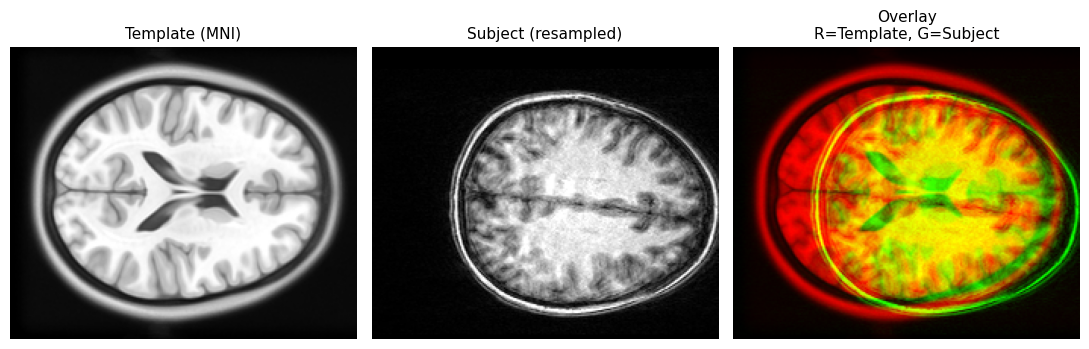

In [6]:
# ---- 1) Resample subject T1 onto the template grid (same shape + affine) ----
from nibabel.processing import resample_from_to
import numpy as np
import matplotlib.pyplot as plt

t1_on_mni = resample_from_to(t1_img, (mni_img.shape, mni_img.affine))

# Load arrays as float32 for plotting
mni  = mni_img.get_fdata(dtype=np.float32)
t1r  = t1_on_mni.get_fdata(dtype=np.float32)

# ---- 2) Choose an axial slice to view (middle by default) ----
k = mni.shape[2] // 2  # change k if you want a different slice

# ---- 3) Robust per-image normalization for display (1–99th percentile) ----
def norm99(x):
    p1, p99 = np.percentile(x, (1, 99))
    if p99 <= p1:  # flat/empty slice guard
        return np.zeros_like(x, dtype=np.float32)
    return np.clip((x - p1) / (p99 - p1), 0, 1).astype(np.float32)

mni_slice = norm99(mni[:, :, k])
t1_slice  = norm99(t1r[:, :, k])

# ---- 4) Build an RGB overlay: R = template, G = subject ----
overlay = np.zeros(mni_slice.shape + (3,), dtype=np.float32)
overlay[..., 0] = mni_slice   # red channel
overlay[..., 1] = t1_slice    # green channel

# ---- 5) Plot: template, subject, and overlay ----
fig, axes = plt.subplots(1, 3, figsize=(11, 3.6))
ax = axes.ravel()

ax[0].imshow(mni_slice, cmap='gray', origin='lower')
ax[0].set_title("Template (MNI)", fontsize=11)

ax[1].imshow(t1_slice, cmap='gray', origin='lower')
ax[1].set_title("Subject (resampled)", fontsize=11)

ax[2].imshow(overlay, origin='lower')
ax[2].set_title("Overlay\nR=Template, G=Subject", fontsize=11)

for a in ax: 
    a.axis('off')

fig.tight_layout()
plt.show()


## 5.3.  Affine registration (Translation → Rigid → Full Affine)

We’ll use **mutual information** (robust across modalities/intensity differences) and a multi-resolution strategy.

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


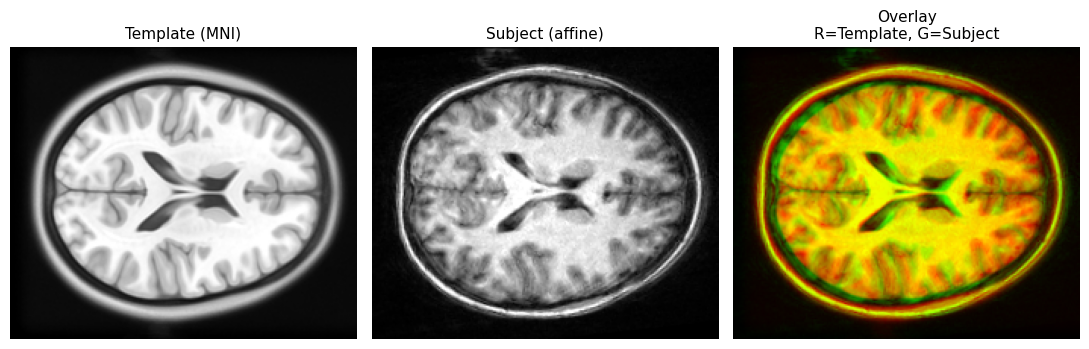

Final affine 4x4 (moving→MNI):
 [[ 8.94329426e-01 -9.92472810e-02  5.58668139e-03 -9.49420861e+00]
 [ 8.98222355e-02  8.93637114e-01 -1.03929107e-01  1.97322858e+01]
 [-1.15247556e-04  1.49856018e-01  7.75875344e-01 -2.98514963e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [7]:
# ============================================================
# Affine registration (3D): Translation → Rigid → Affine (MI)
# - Static (reference): MNI template
# - Moving: subject T1
# - Uses Mutual Information (robust for contrast/scale differences)
# - Chains stages via `starting_affine` to avoid repeated resampling
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

# ---- 1) Define static/moving images + their grid2world affines ----
static          = mni_data.astype(np.float32)
static_affine   = mni_img.affine
moving          = t1_data.astype(np.float32)
moving_affine   = t1_img.affine

# ---- 2) Metric + multi-resolution schedule (coarse → fine) ----
metric       = MutualInformationMetric(nbins=32, sampling_proportion=None)
level_iters  = [10000, 1000, 100]   # iterations per level
sigmas       = [3.0,   1.0,  0.0]   # Gaussian smoothing (voxels)
factors      = [4,     2,    1]     # downsampling factors

affreg = AffineRegistration(metric=metric,
                            level_iters=level_iters,
                            sigmas=sigmas,
                            factors=factors)

# ---- 3) Stage 1: pure translation ----
translation = affreg.optimize(
    static, moving,
    transform=TranslationTransform3D(), params0=None,
    static_grid2world=static_affine,
    moving_grid2world=moving_affine
)

# ---- 4) Stage 2: rigid (rotation + translation), initialized from Stage 1 ----
rigid = affreg.optimize(
    static, moving,
    transform=RigidTransform3D(), params0=None,
    static_grid2world=static_affine,
    moving_grid2world=moving_affine,
    starting_affine=translation.affine
)

# ---- 5) Stage 3: full affine (adds scale + shear), initialized from Stage 2 ----
affine = affreg.optimize(
    static, moving,
    transform=AffineTransform3D(), params0=None,
    static_grid2world=static_affine,
    moving_grid2world=moving_affine,
    starting_affine=rigid.affine
)

# ---- 6) Apply the final affine ONCE (avoids cumulative interpolation blur) ----
t1_affined = affine.transform(moving)  # result on the static (MNI) grid

# ============================================================
# Quick visualization (single slice + robust contrast)
# ============================================================
def _norm99(x):
    p1, p99 = np.percentile(x, (1, 99))
    if p99 <= p1: return np.zeros_like(x, dtype=np.float32)
    return np.clip((x - p1) / (p99 - p1), 0, 1).astype(np.float32)

k = static.shape[2] // 2  # mid axial slice (change if you like)

s2  = _norm99(static[:, :, k])
m2  = _norm99(t1_affined[:, :, k])

overlay = np.zeros(s2.shape + (3,), dtype=np.float32)
overlay[..., 0] = s2  # R = template
overlay[..., 1] = m2  # G = subject (affine)

fig, axes = plt.subplots(1, 3, figsize=(11, 3.6))
ax = axes.ravel()
ax[0].imshow(s2, cmap='gray', origin='lower'); ax[0].set_title("Template (MNI)", fontsize=11)
ax[1].imshow(m2, cmap='gray', origin='lower'); ax[1].set_title("Subject (affine)", fontsize=11)
ax[2].imshow(overlay, origin='lower');         ax[2].set_title("Overlay\nR=Template, G=Subject", fontsize=11)
for a in ax: a.axis('off')
fig.tight_layout(); plt.show()

# (Optional) Inspect the final 4×4 affine matrix
print("Final affine 4x4 (moving→MNI):\n", affine.affine)


**What’s happening above:**

* We align in stages: coarse → fine. This helps avoid local minima.
* `.optimize(...)` computes the best transform to bring the moving image into the static image’s space.
* `.transform(...)` resamples the moving image on the static grid using the current best transform.

##  5.5. Notes, tips, and what to expect

* **Intensity scaling:** For visualization we normalize slices by their max; mutual information handles raw intensities well.
* **Orientation matters:** Using `nib.as_closest_canonical` avoids left/right flips due to different header conventions.
* **This is “global” alignment:** Some structures (sulci/gyri, ventricles) may still be imperfect after affine.

  * For tighter alignment, follow with a **nonlinear** (warp) registration step.
* **Runtime settings:** If results look rough, try more iterations, different `nbins` for MI, or include a **center-of-mass pre-alignment** (DIPY also provides it).
* **Masks help:** Brain masks for static/moving can improve robustness, especially if neck/face are present.

---

# **🧩6.  (`nibabel.processing.resample_from_to`) VS (Registration)**

* **`resample_from_to`** = just **regridding**: it takes an image you already have and **reslices** it onto a target grid (shape + affine) using interpolation. It **does not figure out** how to align anatomy.
* **Registration** = **estimating a transform** that aligns anatomy by **optimizing a cost function** (MI/CC/SSD). It doesn’t touch image data until you **apply** the estimated transform (which is, in fact, a resampling step).



## 6.1. What each one does

**Resampling (`nibabel.processing.resample_from_to`)**

* Inputs: a source image and a target grid (either another image or `(shape, affine)`).
* Action: computes how target voxel coordinates map into the source via the two **header affines** (world→voxel math) and interpolates intensities.
* Output: a new image on the target grid.
* Key point: uses only what’s in the NIfTI headers; **no similarity measure, no optimization**.
* Scope: effectively **linear** regridding by header geometry; **cannot** apply nonlinear warps.

**Registration (affine, SyN, etc.)**

* Inputs: a *fixed* image, a *moving* image, a **cost function** (MI/CC/SSD), and an optimizer schedule.
* Action: **solves for a transform** (rigid/affine or a dense nonlinear field) that best aligns the images.
* Output: a **transform/mapping** (e.g., 4×4 matrix or a displacement field). The pixels aren’t changed yet.
* Next step: you then **apply** that transform to resample the moving image onto the fixed grid (this is a resampling step, using the found transform).

## 6.2. When to use which

* Use **`resample_from_to`** when:

  * Two images are **already in the same space** (e.g., both true MNI) and you just want a **matching grid/voxel size**.
  * You want a quick overlay by putting the moving image on the fixed **grid** (knowing it won’t fix anatomical misalignment).

* Use **registration** when:

  * Images are in **different spaces** (native vs template) or misaligned.
  * You need to **estimate** how to align them (affine or nonlinear).
  * After estimating, you’ll **apply** the transform to produce an aligned image (a resampling step).

## 6.3. How they work together (typical workflow)

1. **Register**: estimate transform $T$ (e.g., affine matrix or SyN warp) by optimizing MI/CC/SSD.
2. **Resample once**: apply $T$ to the moving image to put it on the fixed image’s grid (interpolation).

   * For affine: many libs (DIPY, SimpleITK) give you `.transform(...)`.
   * For nonlinear: use the mapping’s warp function.
   * `resample_from_to` is fine for **affine/header-only** cases; it doesn’t apply nonlinear fields.

## 6.4. Common pitfalls

* Resampling ≠ registration: If the images start in different anatomical spaces, simply calling `resample_from_to` will **not** align anatomy—your overlay will still show mismatch (exactly what you observed before affine/SyN).
* Multiple reslices blur data: **compose transforms** and resample **once** at the end when possible.
* Nonlinear warps: `resample_from_to` cannot apply them; use the registration library’s mapping to warp.

## One-line mental model

* **Registration** decides *how* to move the image (finds $T$).
* **Resampling** actually *moves* it onto a new grid (applies $T$ via interpolation).


----




# **🧩 7.  Diffeomorphic registration (SyN)**

## 7.1 Why move beyond affine?

* **Affine** registration uses one global transform (translate/rotate/scale/shear) to make images overlap. It fixes **global** differences (head size/orientation/FOV) but can’t match **local** anatomy (e.g., ventricle shape, cortical folds).
* **Diffeomorphic** registration adds a **smooth, spatially varying** deformation so nearby voxels move in similar ways. This lets fine structures line up **without tearing or folding** the image.

## 7.2 What “diffeomorphic” means (plain language)

* **Smooth everywhere:** no sharp kinks in the deformation.
* **Invertible:** every point maps to exactly one point; you can go forward **and** back.
* **Topology preserving:** no folding—sulci don’t cross or self-overlap (Jacobians stay positive).
* **Composable:** you can safely chain transforms across steps/sessions.

## 7.3. Quick comparison: Affine vs. Diffeomorphic (SyN)

| Aspect      | Affine                                          | Diffeomorphic (SyN)                                     |
| ----------- | ----------------------------------------------- | ------------------------------------------------------- |
| Model       | 12 DOF global transform                         | Dense, smooth deformation field (via velocity field)    |
| Captures    | Pose + global size/shape                        | Local anatomical variability (ventricles, gyri/sulci)   |
| Invertible? | Yes (matrix inverse)                            | Yes (by design; no folding)                             |
| Risk        | Underfits local detail                          | Over-warping toward template if parameters too loose    |
| Cost        | Fast                                            | Slower, more memory                                     |
| Use for     | Initial T1→MNI alignment; within-subject coarse | Refinement after affine for cross-subject normalization |

> Rule of thumb: **Affine → SyN** is a strong default for bringing individual T1s into MNI before group analyses.

## 7.4. How SyN works (at a glance)

* **S**ymmetric **D**iffeomorphic: optimizes **both** directions (moving→static and static→moving) to reduce bias toward either image.
* Uses a **stationary velocity field**; exponentiating it (scaling-and-squaring) yields a smooth, invertible warp.
* Typically paired with a **local similarity metric**. For same-contrast anatomy (T1↔T1), **cross-correlation (CC)** is robust.
* Runs over a **multi-resolution pyramid** (coarse→fine) to avoid bad minima and speed things up.

---

## 7.5. Practical recipe for our data

We keep:

* **Static (reference):** MNI152NLin2009cAsym 1 mm T1 (TemplateFlow)
* **Moving:** your subject T1 `sub-10159_T1w.nii`
* **Pre-alignment:** the **affine** you already computed (reduces unrealistic large deformations)

---

## 7.6. SyN vs. other nonlinear options (quick context)

* **B-spline free-form deformation (FFD):** flexible, often fast, but not inherently diffeomorphic (can fold if unconstrained).
* **Demons/optical-flow:** simple and fast for mono-modal data; classical forms lack topology guarantees (diffeomorphic variants exist).
* **LDDMM:** very principled diffeomorphic framework with time-varying velocities; powerful but more computationally involved.

Why we like **SyN** here:

* **Symmetric + diffeomorphic** → reduced template bias, invertible forward/backward maps, safe composition across preprocessing steps.
* Strong, widely used default for **T1→MNI** after an affine pre-align.

---


### 1) Set up the SyN optimizer (3D CC metric)

In [35]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric


# Cross-correlation metric in 3D
# radius ~ neighborhood size (in voxels) for local CC; sigma_diff ~ smoothing in metric
metric = CCMetric(3, sigma_diff=2.0, radius=2)

# Multi-resolution schedule (coarse → fine), like in affine:
level_iters = [100, 50, 25]   # keep modest at first; you can increase if needed

sdr = SymmetricDiffeomorphicRegistration(metric, level_iters=level_iters)



### 2) Run SyN, using the affine as a prealign

This refines local details without redoing global shape from scratch.

In [ ]:
static = mni_data
static_affine = mni_img.affine

moving = t1_data
moving_affine = t1_img.affine

# Use your previously estimated affine as a pre-alignment
# (if your affine object is named differently, adjust below)
prealign_affine = affine.affine

# Optimize a smooth, invertible warp (moving -> static)
mapping = sdr.optimize(
    static, moving,
    static_grid2world=static_affine,
    moving_grid2world=moving_affine,
    prealign=prealign_affine
)

# Apply the warp to the subject image (now on the MNI grid)
t1_syn = mapping.transform(moving)

C:\Users\Saye\AppData\Local\Temp\ipykernel_3512\3170215241.py:12: UserWarning: Pass ['static_grid2world', 'moving_grid2world'] as keyword args. From version 2.0.0 passing these as positional arguments will result in an error. 
  mapping = sdr.optimize(static, moving,



### 3) Quick visualization (concise titles)

We’ll reuse the fixed helper and keep titles short & readable.

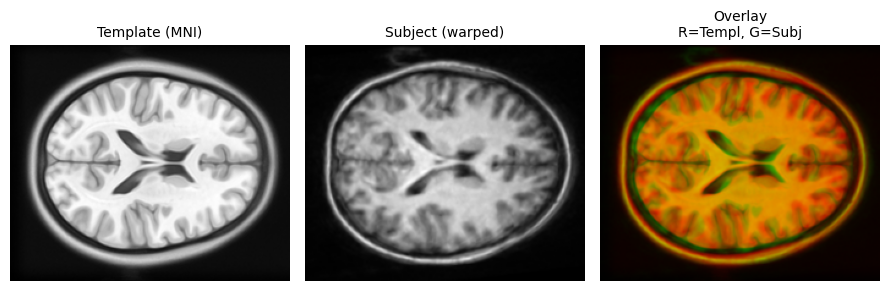

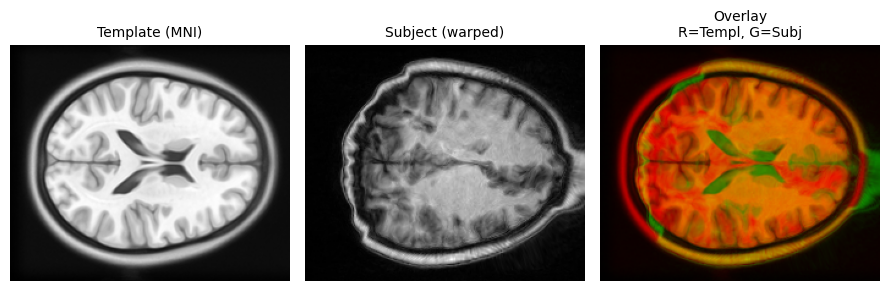

In [17]:
def show_slice_and_blend(static, moving, k=None, title_prefix=""):
    if k is None:
        k = static.shape[2] // 2
    k = int(np.clip(k, 0, static.shape[2]-1))

    s = np.nan_to_num(static, nan=0.0)
    m = np.nan_to_num(moving, nan=0.0)
    s2 = s[:, :, k] / (s.max() or 1.0)
    m2 = m[:, :, k] / (m.max() or 1.0)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3.2))
    ax = axes.ravel()
    ax[0].imshow(s2, cmap='gray', origin='lower'); ax[0].set_title("Template (MNI)", fontsize=10)
    ax[1].imshow(m2, cmap='gray', origin='lower'); ax[1].set_title("Subject (warped)", fontsize=10)

    # simple R/G overlay
    stereo = np.zeros(s2.shape + (3,), dtype=np.uint8)
    stereo[..., 0] = (255*np.clip(s2,0,1)).astype(np.uint8)  # R = template
    stereo[..., 1] = (255*np.clip(m2,0,1)).astype(np.uint8)  # G = subject
    ax[2].imshow(stereo, origin='lower'); ax[2].set_title("Overlay\nR=Templ, G=Subj", fontsize=10)

    for a in ax: a.axis('off')
    fig.tight_layout(); plt.show()

# Compare before/after (use same slice index if you want)
show_slice_and_blend(static, t1_affined, title_prefix="After affine: ")
show_slice_and_blend(static, t1_syn,     title_prefix="After SyN: ")

### 4) SyN (local CC) + DIPY masks (median_otsu) / with overlay_slices visualization (DIPY regtools)

C:\Users\Saye\AppData\Local\Temp\ipykernel_3512\3310321859.py:12: UserWarning: You do not have FURY installed. Some visualization functions might not work for you. Please install or upgrade FURY using pip install -U fury. For detailed installation instructions visit: https://fury.gl/
  from dipy.viz import regtools  # <-- for overlay_slices


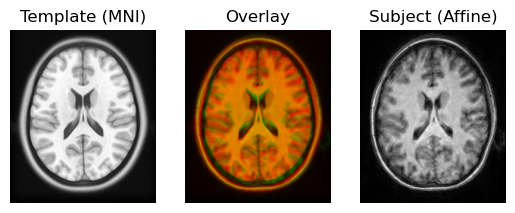

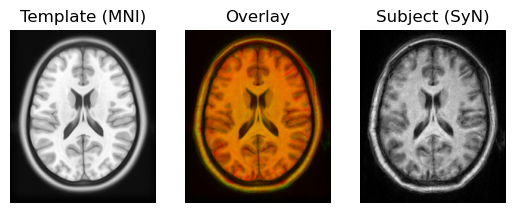

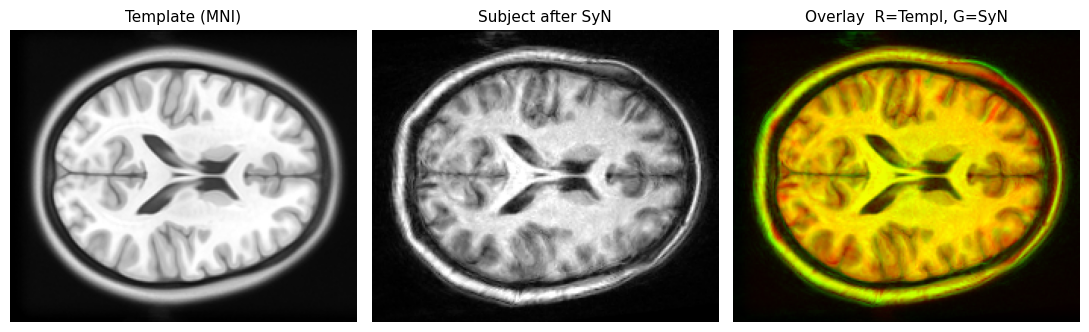

Saved regtools overlays as: overlay_affine.png and overlay_syn.png


In [38]:
# ============================================
# SyN (local CC) + DIPY masks (median_otsu)
# with overlay_slices visualization (DIPY regtools)
# ============================================
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from dipy.segment.mask import median_otsu
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.viz import regtools  # <-- for overlay_slices

# ---- Inputs already defined earlier ----
# static = mni_data;       static_affine = mni_img.affine
# moving = t1_data;        moving_affine = t1_img.affine
# affine = final affine object from your affine pipeline (moving→static)
prealign_affine = affine.affine

static = static.astype(np.float32)
moving = moving.astype(np.float32)

# ---- 1) Brain masks via median_otsu (tutorial-style) ----
# Returns masked data and boolean mask. We’ll use the masks to "soft-mask".
static_masked, static_mask = median_otsu(
    static, vol_idx=None, median_radius=4, numpass=4, autocrop=False, dilate=1, finalize_mask=True
)
moving_masked, moving_mask = median_otsu(
    moving, vol_idx=None, median_radius=4, numpass=4, autocrop=False, dilate=1, finalize_mask=True
)

# Soft edges (avoid hard mask boundaries in the metric)
try:
    from scipy.ndimage import gaussian_filter
    s_w = gaussian_filter(static_mask.astype(np.float32), sigma=1.0)
    m_w = gaussian_filter(moving_mask.astype(np.float32), sigma=1.0)
except Exception:
    s_w = static_mask.astype(np.float32)
    m_w = moving_mask.astype(np.float32)

# Soft-masked copies used for optimization
static_soft = static * s_w
moving_soft = moving * m_w

# ---- 2) SyN with local CC (conservative settings) ----
metric = CCMetric(3, radius=3, sigma_diff=2.0)
sdr = SymmetricDiffeomorphicRegistration(
    metric,
    level_iters=[300, 150, 75],   # coarse → fine
    step_length=0.10,             # safer step
    ss_sigma_factor=0.2,          # smooth update field
    inv_iter=50,
    opt_tol=1e-5
)

# ---- 3) Optimize on soft-masked images (broadly compatible across DIPY versions) ----
mapping = sdr.optimize(
    static_soft, moving_soft,
    static_grid2world=static_affine,
    moving_grid2world=moving_affine,
    prealign=prealign_affine
)

# Apply SyN and (for comparison) the affine-only result
t1_syn = mapping.transform(moving)   # nonlinear result on MNI grid
t1_aff = affine.transform(moving)    # affine-only result on MNI grid

# -------------------------------------------------------
# 4) Visualization with DIPY regtools.overlay_slices
# -------------------------------------------------------
# slice_type: 0=sagittal, 1=coronal, 2=axial (use 2 to match your earlier axial views)
slice_idx  = static.shape[2] // 2
slice_type = 2  # axial

# (A) Affine overlay
regtools.overlay_slices(
    static, t1_aff,
    slice_index=slice_idx,
    slice_type=slice_type,
    ltitle="Template (MNI)",
    rtitle="Subject (Affine)",
    fname="overlay_affine.png"
)

# (B) SyN overlay
regtools.overlay_slices(
    static, t1_syn,
    slice_index=slice_idx,
    slice_type=slice_type,
    ltitle="Template (MNI)",
    rtitle="Subject (SyN)",
    fname="overlay_syn.png"
)

# -------------------------------------------------------
# (Optional) Also show a quick 3-panel figure with robust contrast
# -------------------------------------------------------
def norm99(x):
    p1, p99 = np.percentile(x, (1, 99))
    if p99 <= p1: return np.zeros_like(x, dtype=np.float32)
    return np.clip((x - p1) / (p99 - p1), 0, 1).astype(np.float32)

S = norm99(static[:, :, slice_idx])
A = norm99(t1_aff[:, :, slice_idx])
Y = norm99(t1_syn[:, :, slice_idx])

ov_aff = np.zeros(S.shape + (3,), dtype=np.float32); ov_aff[..., 0] = S; ov_aff[..., 1] = A
ov_syn = np.zeros(S.shape + (3,), dtype=np.float32); ov_syn[..., 0] = S; ov_syn[..., 1] = Y

fig, axes = plt.subplots(1, 3, figsize=(11, 3.6))
axes[0].imshow(S, cmap='gray', origin='lower'); axes[0].set_title("Template (MNI)", fontsize=11); axes[0].axis('off')
axes[1].imshow(Y, cmap='gray', origin='lower'); axes[1].set_title("Subject after SyN", fontsize=11); axes[1].axis('off')
axes[2].imshow(ov_syn, origin='lower');         axes[2].set_title("Overlay  R=Templ, G=SyN", fontsize=11); axes[2].axis('off')
fig.tight_layout(); plt.show()

print("Saved regtools overlays as: overlay_affine.png and overlay_syn.png")


---



You don’t *always* need a mask for diffeomorphic registration—but in practice it almost always helps, and sometimes it’s essential. Here’s why.

# **🧩 Why masking helps (especially for SyN / diffeomorphic)**

1. **Focus the similarity metric on brain tissue.**
   Local CC (the usual metric for SyN) compares intensities in small windows. Background air (near-zero), fat, scalp, neck, or the skull can dominate those windows and mislead the optimizer. A brain mask tells the algorithm: “optimize similarity *here*, not out in air or bone.”

2. **Prevent spurious warps at the head boundary.**
   Diffeomorphic warps are very flexible. Without a mask, the optimizer can “chase” differences in the scalp/neck/cushion or different field-of-view, pulling the brain outward and wasting degrees of freedom on non-brain structures.

3. **Reduce bias from different FOV / padding.**
   If one image includes lower neck/shoulders and the template doesn’t, unmasked metrics try to match incomparable regions, inflating the joint cost and encouraging large, unnecessary deformations.

4. **Improve stability and convergence.**
   By removing irrelevant/low-information voxels, the cost surface is cleaner. Optimizers take more reliable steps and settle faster.

5. **Protect topology near edges.**
   Diffeomorphic methods enforce invertibility, but strong, misdirected gradients near the skull can still push toward extreme expansions/compressions. Masks damp those forces where anatomy isn’t comparable.

6. **Speed.**
   Fewer voxels contribute to the metric → cheaper evaluations and gradients.

# When a mask is especially important

* **Cross-subject to template** (T1→MNI): head shape, scalp thickness, and FOV differ.
* **EPI (BOLD) → T1**: susceptibility artifacts + non-brain signal can mislead local CC.
* **Different scanners or coil setups**: background/intensity edges are inconsistent.
* **Any time the overlay shows big mismatches outside brain** that you don’t care to align.

# When you might skip the mask

* **Rigid or affine within-subject** with similar FOVs and good intensity normalization.
* **Debugging**: sometimes you try both masked and unmasked to see where forces are coming from.

# Best practices for masks

* **Make masks in each image’s native space** (e.g., `median_otsu` on T1; a functional brain extraction on EPI) and use them where the metric is computed.
* **Don’t be too tight.** Lightly **dilate 1–2 voxels** so sulci/cortex aren’t clipped.
* Prefer **soft masks (weights)** over hard cutouts: blur the binary mask slightly (e.g., Gaussian σ≈1) to avoid sharp boundaries that can create artificial gradients.
* **Keep cerebellum/brainstem** if you care about aligning them; cropping them out constrains what the warp can learn.
* If your library/version can’t pass masks directly, **multiply the images by the (soft) mask** before optimization (what we did above).

# TL;DR

Masks are not a mathematical requirement for diffeomorphic registration, but they are a **practical tool** that:

* directs the metric to brain tissue,
* avoids misleading background/skull signals,
* improves stability and speed,
* and prevents unrealistic warps at the head boundary.

That’s why most neuroimaging tutorials (including DIPY’s) recommend brain masking before running SyN.



---

## Getting a brain mask in DIPY (most popular choice)

### ✅ Go-to method: `median_otsu`

DIPY’s **`dipy.segment.mask.median_otsu`** is the standard, tutorial-friendly way to extract a brain mask. It combines:

* **Median filtering** (denoise, suppress salt-and-pepper/background)
* **Otsu thresholding** (separates brain from non-brain automatically)
* Optional **dilation** and **autocrop** for a cleaner, slightly expanded mask

**What you pass in**

* `input_volume`: a 3D volume **in native space** (e.g., T1w, or a mean-EPI / mean-b0 for fMRI/DWI)
* `vol_idx`: if you give a 4D array, choose which volumes to use (e.g., `vol_idx=[0]` or a small list). For fMRI, it’s common to pass a **temporal mean** (`np.mean(func, axis=3)`) to `median_otsu`.

**Typical, reliable settings**

* `median_radius=4`, `numpass=4` — what the DIPY examples use (good default)
* `autocrop=False` — keep full FOV while making the mask
* `dilate=1` — expand by \~1 voxel so the mask isn’t too tight at cortex/CSF
* `finalize_mask=True` — return the **binary mask** directly

**Returns**

* `(masked_volume, mask)` where `mask` is a boolean 3D array; `masked_volume = input_volume * mask`.

**Why it’s good for SyN**

* It’s fast, robust on structural and mean-EPI images, and **reduces background/skull drive** on the CC metric used by diffeomorphic registration.

---

### Parameter cheat-sheet (when to tweak)

* **Mask too tight (missed cortex/CSF):** increase `dilate` (e.g., 2), or reduce `numpass` slightly.
* **Mask too loose (includes skull):** decrease `dilate` to 0, or raise `numpass` to 5–6.
* **Noisy EPI/DWI:** keep `median_radius=4`, consider `numpass=5–6`; compute mask on **mean-EPI** or **mean-b0**.
* **Soft edges for metric (recommended):** lightly blur the binary mask for weighting (e.g., Gaussian σ≈1) to avoid sharp boundaries in the similarity measure.

---

### Minimal usage pattern (concept)

1. Create mask in **native** space with `median_otsu`.
2. (Optionally) **soften** mask edges (small Gaussian blur) → weight image by mask.
3. Run **affine** (often with MI) → run **SyN** (local CC) using masked/weighted images.
4. Apply the final transform chain once to resample data into template space.

That’s it—`median_otsu` is the common, dependable choice in DIPY for brain masking before diffeomorphic registration.

---
---

# **🧩 8. Visualize the displacement field **

A diffeomorphic registration (e.g., SyN) estimates a **smooth, invertible mapping** between images. What you can visualize is its **displacement field**:

* **Field definition.** For each voxel at index **x** in the **static** grid, the forward field **u(x)** tells you where the corresponding sample is taken in the **moving** image.

  * **Forward field**: `moving ⟵ static` (often returned as `get_forward_field()`).
  * **Backward field**: `static ⟵ moving` (often returned as `get_backward_field()`).
* **Units.** Most libraries return **voxel-space** displacements (Δi, Δj, Δk). To convert to **millimeters**, multiply by voxel sizes from the affine.

 ### 📌 **Example**

Imagine one voxel at location (50, 60, 40) in the static image.

The algorithm may decide:

> “To match the moving image, this voxel should come from position (52, 58, 41).”

So the **displacement** is:

* Δx = +2
* Δy = –2
* Δz = +1

So the **displacement vector** is:

```
u = (2, -2, 1)
```

That’s all a displacement field is — a grid full of these vectors.

### What to plot (and why)

1. **Magnitude map**

   * Shows how far voxels were displaced:

     $$
     \|u(x)\| = \sqrt{u_x^2 + u_y^2 + u_z^2}
     $$
   * Good for spotting **where** large deformations occur (e.g., near ventricles, cortex folds, FOV edges).
   * Tip: normalize with a robust range (e.g., 1–99th percentile) so outliers don’t wash out detail.

2. **Quiver (arrow) plot on a slice**

   * Downsample the grid (e.g., every 4–8 voxels) to keep it readable.
   * Plot **arrows** for the in-plane components (e.g., $u_x, u_y$ on an axial slice).
   * Scale arrows consistently across before/after comparisons; add a scale bar or legend (“1 arrow unit = X voxels/mm”).

3. **Warped-grid overlay (optional but insightful)**

   * Draw a regular lattice on the static image and warp it with the field.
   * Intuition boost: straight lines bend where local deformations occur.

4. **Direction-colored displacement (optional)**

   * Map **direction** to hue and **magnitude** to brightness. Useful when arrows clutter the view.

### Slices and views

* Show at least one **mid-axial** slice for a quick look, but also check **sagittal** and **coronal** slices where structures of interest deform most.
* Always report the **slice index** and **plane** to make comparisons reproducible.

### Interpreting the field (quality checks)

* **Smoothness:** Diffeomorphic fields should vary smoothly; noisy “salt-and-pepper” vectors suggest metric issues, masking problems, or too-aggressive settings.
* **Edges/FOV:** Large vectors at the skull or outside the brain often mean background influenced the metric—tighten masks or weighting.
* **Symmetry & plausibility:** Expect bigger displacements around variable anatomy (lateral ventricles, frontal/occipital poles) and smaller inside rigid regions (deep WM).
* **Forward vs backward consistency:** Forward and backward fields should be consistent inverses; big inconsistencies can flag convergence issues.

### Derived maps you may want

* **Jacobian determinant** $J(x)=\det(\nabla \phi(x))$:

      **The Jacobian determinant tells us how much each tiny region of the image was stretched or squeezed by the non-linear registration. A value of 1 means no change, >1 means expansion, <1 means compression.**

      # 🔢 **Meaning of Jacobian values**

| Value of Jacobian | Meaning          | Interpretation                                  |
| ----------------- | ---------------- | ----------------------------------------------- |
| **= 1**           | No change        | voxel volume stays the same                     |
| **> 1**           | Expansion        | region got bigger (stretched)                   |
| **< 1**           | Compression      | region shrank                                   |
| **= 0**           | Collapsed region | invalid deformation (not allowed)               |
| **< 0**           | Folding          | *not diffeomorphic* / wrong (SyN prevents this) |

  * $J>0$ everywhere for a valid diffeomorphism.
  * $J>1$: local **expansion**; $0<J<1$: **compression**.
  * **log-Jacobian** is common for group statistics (voxel-based morphometry–like analyses).
* **Strain/Bending energy** (advanced): summarize how “costly” the deformation is; useful for regularization tuning.

### Practical tips

* **Masking helps.** Compute/visualize fields **inside a (soft) brain mask** to avoid being misled by air/skull.
* **Voxel vs mm.** When communicating results, prefer **millimeters**.
* **Consistent windows.** Use the **same color scale** and downsampling across subjects to compare fairly.
* **One resample at the end.** Compose transforms and resample once to avoid interpolation blur in the images you overlay under the vectors.

**TL;DR**
Use the **magnitude map** to see *where* the warp works hardest, **quiver** to see *how* it moves locally, and **(log-)Jacobian** to judge if the deformation is anatomically plausible and topology-preserving.


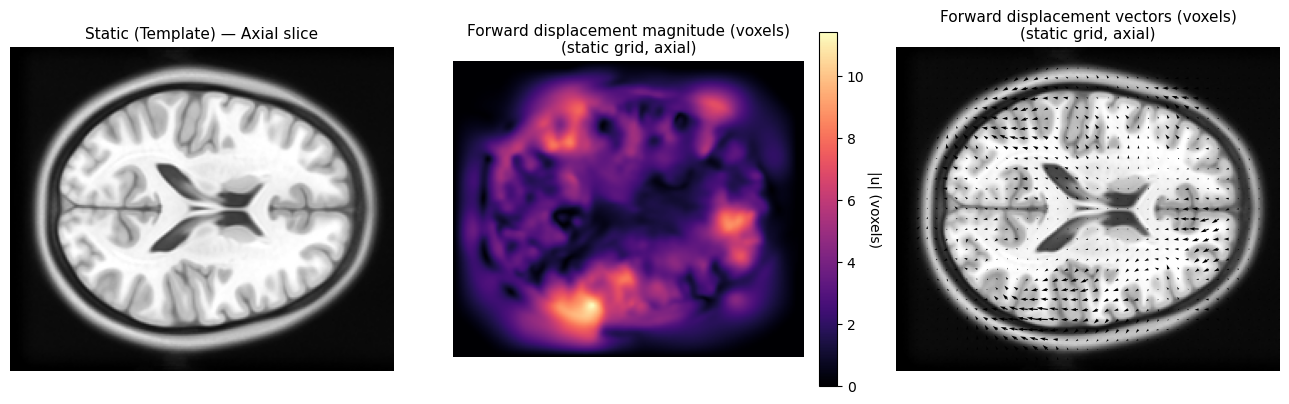

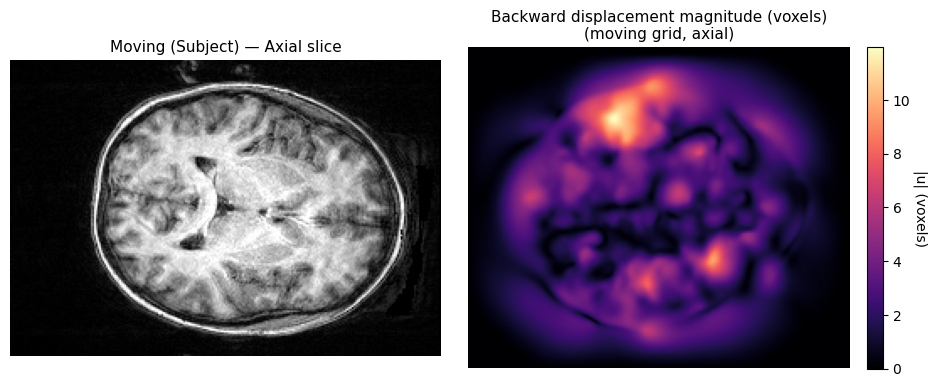

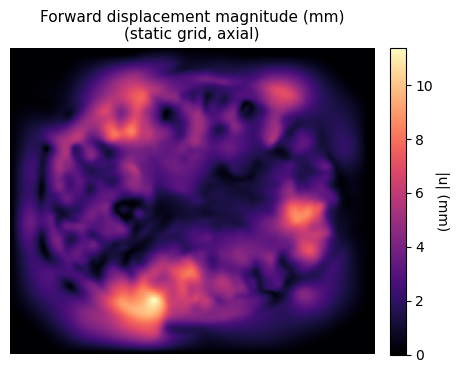

In [40]:
# ===========================================================
# Displacement field visualization (forward & backward)
# Requires:
#   mapping          -> from SyN (sdr.optimize)
#   static, moving   -> 3D arrays
#   static_affine, moving_affine -> 4x4 affines (used if you later want mm units)
# ===========================================================
import numpy as np
import matplotlib.pyplot as plt

# ---- 1) Get forward/backward fields (in VOXEL units) ----
# forward: defined on STATIC grid; backward: on MOVING grid
fwd = mapping.get_forward_field()    # shape: (X, Y, Z, 3)
bwd = mapping.get_backward_field()   # shape: (X, Y, Z, 3)

# ---- 2) Pick mid-axial slices on each grid ----
k_static = static.shape[2] // 2
k_moving = moving.shape[2] // 2

# Forward (STATIC grid): components along array axes
Fx = fwd[:, :, k_static, 0]  # displacement along axis-0 (rows)
Fy = fwd[:, :, k_static, 1]  # displacement along axis-1 (cols)
Fmag_vox = np.sqrt(Fx**2 + Fy**2)

# Backward (MOVING grid) for reference
Bx = bwd[:, :, k_moving, 0]
By = bwd[:, :, k_moving, 1]
Bmag_vox = np.sqrt(Bx**2 + By**2)

# ---- 3) Normalized background images for overlay (robust 1–99% per-slice) ----
def norm99_slice(a):
    p1, p99 = np.percentile(a, (1, 99))
    if p99 <= p1: 
        return np.zeros_like(a, dtype=np.float32)
    return np.clip((a - p1) / (p99 - p1), 0, 1).astype(np.float32)

S_ax = norm99_slice(static[:, :, k_static])
M_ax = norm99_slice(moving[:, :, k_moving])

# ---- 4) Quiver sampling (keep arrows readable) ----
H, W = Fx.shape
step = max(2, min(H, W) // 32)       # ~32 arrows across the smallest dimension
ys = np.arange(0, H, step)           # row indices
xs = np.arange(0, W, step)           # col indices
Xg, Yg = np.meshgrid(xs, ys)         # (rows, cols) grids for quiver positions

# IMPORTANT: For an image with origin='lower':
#   - X (quiver horizontal) should use Fy (displacement along axis-1 / columns)
#   - Y (quiver vertical)   should use Fx (displacement along axis-0 / rows)
U = Fy[ys[:, None], xs[None, :]]
V = Fx[ys[:, None], xs[None, :]]

# ---- 5) Plot: Forward field (axial) ----
fig, ax = plt.subplots(1, 3, figsize=(13, 4.2))

# (A) Static slice (background)
im0 = ax[0].imshow(S_ax, cmap='gray', origin='lower')
ax[0].set_title("Static (Template) — Axial slice", fontsize=11)
ax[0].axis('off')

# (B) Forward displacement magnitude (voxels)
im1 = ax[1].imshow(Fmag_vox, cmap='magma', origin='lower')
ax[1].set_title("Forward displacement magnitude (voxels)\n(static grid, axial)", fontsize=11)
ax[1].axis('off')
cbar1 = plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
cbar1.set_label("|u| (voxels)", rotation=270, labelpad=12)

# (C) Quiver overlay (arrows in voxel units, forward field)
ax[2].imshow(S_ax, cmap='gray', origin='lower')
ax[2].quiver(Xg, Yg, U, V, angles='xy', scale_units='xy', scale=1.5, width=0.003)
ax[2].set_title("Forward displacement vectors (voxels)\n(static grid, axial)", fontsize=11)
ax[2].axis('off')

fig.tight_layout()
plt.show()

# ---- 6) Plot: Backward field magnitude (axial, moving grid) ----
fig, ax = plt.subplots(1, 2, figsize=(9.5, 3.8))

# (A) Moving slice (background)
ax[0].imshow(M_ax, cmap='gray', origin='lower')
ax[0].set_title("Moving (Subject) — Axial slice", fontsize=11)
ax[0].axis('off')

# (B) Backward displacement magnitude (voxels)
imB = ax[1].imshow(Bmag_vox, cmap='magma', origin='lower')
ax[1].set_title("Backward displacement magnitude (voxels)\n(moving grid, axial)", fontsize=11)
ax[1].axis('off')
cbarB = plt.colorbar(imB, ax=ax[1], fraction=0.046, pad=0.04)
cbarB.set_label("|u| (voxels)", rotation=270, labelpad=12)

fig.tight_layout()
plt.show()

# ---- 7) (Optional) Convert to millimeters on the shown slice ----
# If you want mm magnitudes for reporting, scale each component by voxel sizes.
def voxel_sizes_mm(aff):
    # length of each column vector of the 3x3 part of the affine
    return np.sqrt((aff[:3, :3] ** 2).sum(axis=0))

vs_static = voxel_sizes_mm(static_affine)   # (sx, sy, sz) mm
Fmag_mm_axial = np.sqrt((Fx * vs_static[0])**2 + (Fy * vs_static[1])**2)

plt.figure(figsize=(4.8, 3.8))
im = plt.imshow(Fmag_mm_axial, cmap='magma', origin='lower')
plt.title("Forward displacement magnitude (mm)\n(static grid, axial)", fontsize=11)
plt.axis('off')
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label("|u| (mm)", rotation=270, labelpad=12)
plt.tight_layout()
plt.show()


### A) Forward field (defined on the **static/template** grid), vectors on an axial slice — **voxel units**

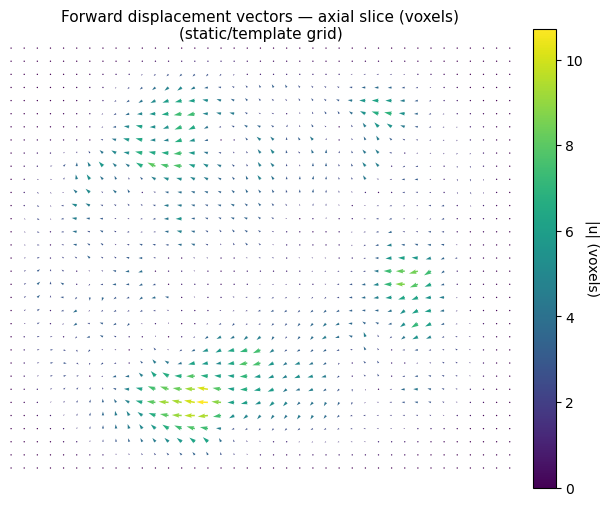

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Forward field u_fwd (static grid) and an axial slice index
fwd = mapping.get_forward_field()          # shape: (X, Y, Z, 3), voxel units
k = static.shape[2] // 2                   # mid axial slice

Fx = fwd[:, :, k, 0]                       # displacement along rows (axis-0)
Fy = fwd[:, :, k, 1]                       # displacement along cols (axis-1)
Fmag = np.sqrt(Fx**2 + Fy**2)              # in-plane magnitude (voxels)

# 2) Build a sparse grid for arrows (keeps it readable)
H, W = Fx.shape
step = max(2, min(H, W) // 32)             # ~32 arrows across the smaller dim
ys = np.arange(0, H, step)                 # row indices
xs = np.arange(0, W, step)                 # col indices
Xg, Yg = np.meshgrid(xs, ys)

# 3) Sample vectors & colors on that sparse grid
U = Fy[ys[:, None], xs[None, :]]           # horizontal component (cols)
V = Fx[ys[:, None], xs[None, :]]           # vertical component (rows)
C = Fmag[ys[:, None], xs[None, :]]         # color = magnitude

# 4) Plot vectors on a blank (white) canvas with image-like orientation (origin='lower')
blank = np.ones((H, W), dtype=np.float32)  # just to set the coordinate system
fig, ax = plt.subplots(figsize=(6.2, 5.2))
ax.imshow(blank, cmap='gray', vmin=0, vmax=1, origin='lower')
Q = ax.quiver(Xg, Yg, U, V, C, cmap='viridis',
              angles='xy', scale_units='xy', scale=2.0, width=0.003)
cbar = plt.colorbar(Q, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("|u| (voxels)", rotation=270, labelpad=12)

ax.set_title("Forward displacement vectors — axial slice (voxels)\n(static/template grid)", fontsize=11)
ax.axis('off')
plt.tight_layout()
plt.show()


### B) Same forward vectors, but **scaled to millimeters**

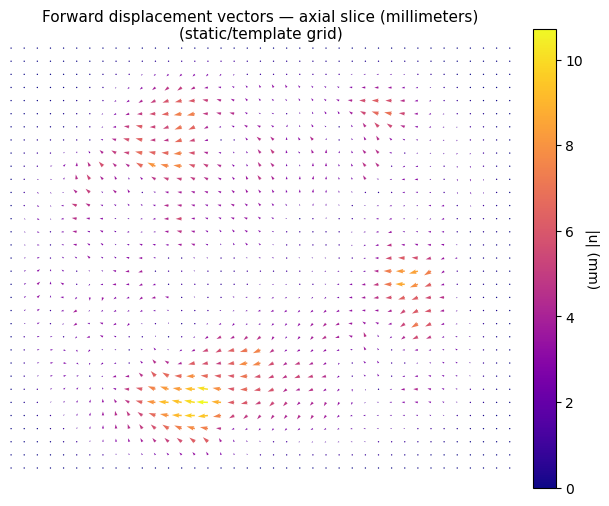

In [43]:
# Convert components to mm using voxel sizes from the static/template affine
def voxel_sizes_mm(aff):
    return np.sqrt((aff[:3, :3]**2).sum(axis=0))  # (sx, sy, sz)

vs = voxel_sizes_mm(static_affine)               # (mm per voxel) along (row, col, slice)
U_mm = U * vs[1]                                 # horizontal: columns → scale by sy
V_mm = V * vs[0]                                 # vertical: rows    → scale by sx
C_mm = np.sqrt(U_mm**2 + V_mm**2)                # magnitude in mm

fig, ax = plt.subplots(figsize=(6.2, 5.2))
ax.imshow(blank, cmap='gray', vmin=0, vmax=1, origin='lower')
Qmm = ax.quiver(Xg, Yg, U_mm, V_mm, C_mm, cmap='plasma',
                angles='xy', scale_units='xy', scale=2.0, width=0.003)
cbar = plt.colorbar(Qmm, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("|u| (mm)", rotation=270, labelpad=12)

ax.set_title("Forward displacement vectors — axial slice (millimeters)\n(static/template grid)", fontsize=11)
ax.axis('off')
plt.tight_layout()
plt.show()


### C) Backward field (defined on the **moving/subject** grid), vectors on an axial slice — **voxel units**

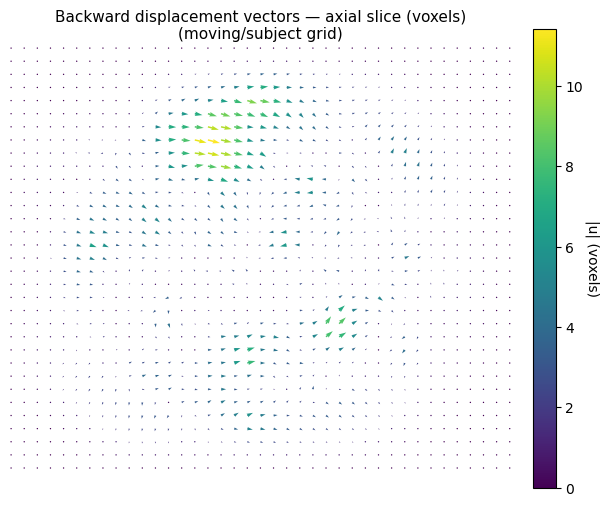

In [44]:
# Backward field u_bwd (moving grid)
bwd = mapping.get_backward_field()         # shape: (X, Y, Z, 3), voxel units
k_m = moving.shape[2] // 2                 # mid axial slice of moving

Bx = bwd[:, :, k_m, 0]
By = bwd[:, :, k_m, 1]
Bmag = np.sqrt(Bx**2 + By**2)

H2, W2 = Bx.shape
step2 = max(2, min(H2, W2) // 32)
ys2 = np.arange(0, H2, step2)
xs2 = np.arange(0, W2, step2)
Xg2, Yg2 = np.meshgrid(xs2, ys2)

U2 = By[ys2[:, None], xs2[None, :]]        # horizontal on moving grid
V2 = Bx[ys2[:, None], xs2[None, :]]        # vertical on moving grid
C2 = Bmag[ys2[:, None], xs2[None, :]]

blank2 = np.ones((H2, W2), dtype=np.float32)

fig, ax = plt.subplots(figsize=(6.2, 5.2))
ax.imshow(blank2, cmap='gray', vmin=0, vmax=1, origin='lower')
Q2 = ax.quiver(Xg2, Yg2, U2, V2, C2, cmap='viridis',
               angles='xy', scale_units='xy', scale=2.0, width=0.003)
cbar = plt.colorbar(Q2, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("|u| (voxels)", rotation=270, labelpad=12)

ax.set_title("Backward displacement vectors — axial slice (voxels)\n(moving/subject grid)", fontsize=11)
ax.axis('off')
plt.tight_layout()
plt.show()


**Notes**

* The blank `imshow(..., origin='lower')` sets an **image-like coordinate system** (0,0 at bottom-left), so the arrows point in the same directions as your other slice plots.
* `U` is the **horizontal** component (columns), `V` the **vertical** component (rows).
* Tweak `step` and `scale` if arrows are too dense or too short/long.
* For sagittal/coronal views, select a different slice and use the appropriate component pairs (e.g., $(u_x, u_z)$ or $(u_y, u_z)$).


##  Quick Q\&A

* **Does SyN fix affine’s issues?**
  Usually yes for many **local mismatches** (ventricle shape/position, some gyri/sulci alignment). You should see tighter overlays.

* **Common pitfalls / things to watch:**

  * **Over-warping** to the template’s anatomy (can erase genuine subject variability).
    *Mitigation:* use reasonable `level_iters`, modest metric radius, and good pre-alignment; consider adding tissue masks.
  * **Template bias:** every subject is bent toward the template’s shape; group statistics may be affected.
  * **Runtime/instability:** SyN is heavier than affine; poor initialization or wildly different FOVs can cause weird warps.
    *Mitigation:* crop/brain-extract, ensure orientations (RAS+), and use the **affine prealign** (as we did).
  * **Applying warps consistently:** Always apply the **same** affine+warp to all images derived from the T1 space (e.g., EPI, masks), so everything stays in register.

## Tuning & troubleshooting

* **Metric (CCMetric)**

  * `radius`: neighborhood size (2–4 is a common start). Larger → more context, smoother match.
  * `sigma_diff`: smoothing for the metric; small values (1–3) are typical.
* **Pyramid schedule**

  * `level_iters`: increase to `[200,100,50]` (or more) for tougher cases.
  * If images differ a lot in FOV or contrast, first fix with **affine** (as we do) and consider brain masks.
* **Contrast considerations**

  * T1→T1 (our case): CC is great.
  * Very different contrasts: CC may still work, but mutual information (for affine) can be more robust for the coarse step.
* **Over-warping**

  * Watch overlays and displacement magnitudes. If you see implausible expansions/compressions, reduce `level_iters`, try smaller `radius`, or use brain masks to focus the metric.
* **Consistency**

  * Apply **the same affine+warp** to all other subject images (EPI, masks) that originate from T1 space.

  ### Take-home

* Use **Affine → SyN** to bring individual T1s into MNI: affine handles global pose/scale; SyN refines local anatomy **without tearing**.
* Keep parameters reasonable, pre-align, and QC with overlays + displacement fields to ensure realistic warps.


---

# TL;DR — SyN vs other registration methods

| Family                    | Transform model                                    | What it captures                                           | Guarantees                                                                  | Typical metric   | Pros                                                                           | Cons                                                                               | When to use                                                           |
| ------------------------- | -------------------------------------------------- | ---------------------------------------------------------- | --------------------------------------------------------------------------- | ---------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------------------------------------- | --------------------------------------------------------------------- |
| **Rigid**                 | 6 DOF (translate + rotate)                         | Head pose                                                  | Invertible                                                                  | MI / NCC         | Fast, robust                                                                   | No size/shape change                                                               | Within-subject EPI↔T1 pre-align                                       |
| **Affine**                | 12 DOF (+ scale + shear)                           | Global size/orientation                                    | Invertible                                                                  | MI / NCC         | Handles scanner/FOV diffs                                                      | No local shape                                                                     | T1→template initial align; between-subject coarse                     |
| **B-spline FFD**          | Local cubic B-splines on a control-point grid      | Smooth local deformations                                  | *Not* guaranteed diffeomorphic unless constrained                           | MI / CC          | Flexible, fast-ish                                                             | Can fold/topology break if over-aggressive; bias toward fixed image                | Anatomical T1→template nonlinear; when speed/flexibility OK           |
| **Demons / Optical-flow** | Dense displacement field                           | Local deformations                                         | Classic demons: no topo guarantee; **diffeomorphic demons** adds it         | SSD / NCC        | Simple, fast for mono-modal                                                    | Sensitive to intensity differences; may need smoothing                             | Same-contrast images (e.g., T1↔T1)                                    |
| **SyN (ANTs / DIPY)**     | Stationary velocity field; exp map gives warp      | Large, smooth, **invertible (diffeomorphic)** deformations | **Yes** (positive Jacobian; no folding) + **symmetric** updates reduce bias | CC (often) or MI | Excellent anatomical alignment; invertible fwd/back; compose transforms safely | Heavier compute/memory; can over-regularize or over-warp if mis-set; template bias | High-quality cross-subject normalization (T1→MNI), post-affine refine |
| **LDDMM**                 | Time-varying velocity (geodesic)                   | Very large deformations                                    | **Yes** (diffeomorphism)                                                    | SSD / variants   | Theoretical gold standard                                                      | Computationally expensive, more parameters                                         | Research/when maximal fidelity needed                                 |
| **BBR (boundary-based)**  | Rigid (sometimes affine) using WM/GM edge contrast | Geometric alignment to cortical boundary                   | Invertible                                                                  | Edge cost        | Great for EPI→T1                                                               | Needs good surfaces/contrast                                                       | EPI→T1 (FSL `epi_reg`, FreeSurfer `bbregister`)                       |

**Why SyN?**

* It’s **diffeomorphic** (smooth, invertible, no tearing) and **symmetric** (reduces bias toward either image).
* That makes it a strong default for **T1→template** normalization after an affine pre-align.

**Why not always SyN?**

* It’s slower and can “overfit” local anatomy toward the template if regularization is weak (masking/parameters matter).
* For **within-subject** tasks (EPI→T1), rigid/BBR often beats any nonlinear warp.

---


**What to look for when you compare to SyN:**

* B-spline can often tighten local alignment similarly.
* But it **doesn’t guarantee** an invertible, fold-free warp. If you crank up control-point density or iterations, you may see unrealistic local compressions/expansions (watch Jacobians if you compute them).

---

## Practical “which should I use?” cheatsheet

* **EPI→T1 (same subject)**: Rigid (or BBR).
* **T1→MNI (between subjects)**: Affine → **SyN**.
* **Speed matters / quick QC**: Affine only (or a coarse B-spline).
* **Highest anatomical fidelity / group analyses**: Affine → **SyN** (or LDDMM if you can afford it).
* **Multi-modal** (T1 vs T2/PD): Prefer **MI** (affine) and **CC** (nonlinear, same-contrast) or MI if contrasts differ.



___

# **TASKS**


# 🟢  Task 1 — Warm-up (Easy): See and quantify misalignment in 2D

**Goal.** Create a misaligned image pair, visualize the misalignment with a red/green “stereo” overlay, and compute a simple before/after difference.

**Dataset.** `skimage.data.astronaut()` (built-in).
**Why here?** Your notebook starts with a simple 2D toy example and a stereo overlay to make the idea concrete. (It later moves to neuroimaging.) 

**steps:**

1. Load the 2D image and convert to grayscale.
2. Build a known *similarity transform* (scale + rotate + translate) and warp to create a misaligned “moving” image.
3. Show a red/green overlay (fixed = red, moving = green).
4. Compute a simple mean absolute difference (MAD) as a “cost” before (no registration yet).

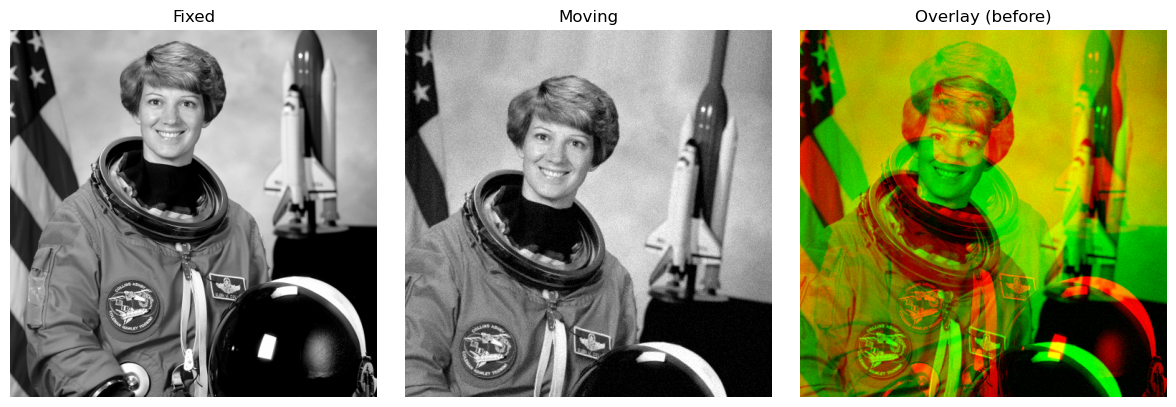

Mean |fixed - moving| (before): 0.2459


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, transform, util

# 1) Fixed image (grayscale)
img_rgb = data.astronaut()
fixed = color.rgb2gray(img_rgb).astype(np.float32)

# 2) Make a known misalignment (similarity transform)
true_shift = (12.5, -8.0)    # (row, col)
true_angle = 8.0             # degrees
true_scale = 1.07
tform_true = transform.SimilarityTransform(
    scale=true_scale,
    rotation=np.deg2rad(true_angle),
    translation=(true_shift[1], true_shift[0])
)

# Moving image = warped (plus tiny noise)
moving = transform.warp(fixed, inverse_map=tform_true.inverse, mode="edge").astype(np.float32)
moving = util.random_noise(moving, mode='gaussian', var=0.001).astype(np.float32)

# 3) Stereo overlay (R=fixed, G=moving)
stereo = np.dstack([fixed, moving, np.zeros_like(fixed)])

# 4) Simple difference metric
mad_before = np.mean(np.abs(fixed - moving))

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(fixed,  cmap='gray'); ax[0].set_title("Fixed");  ax[0].axis("off")
ax[1].imshow(moving, cmap='gray'); ax[1].set_title("Moving"); ax[1].axis("off")
ax[2].imshow(np.clip(stereo, 0, 1)); ax[2].set_title("Overlay (before)"); ax[2].axis("off")
plt.tight_layout(); plt.show()

print(f"Mean |fixed - moving| (before): {mad_before:.4f}")




---

## 🧠 Task 2 – 2D Affine Registration with Mutual Information

### 🎯 Goal

Use DIPY to align a 2D brain slice that has been artificially misaligned.
You’ll apply **affine registration** with **Mutual Information (MI)** and visualize the result.



### 🪜 Steps

1. **Load the data**

   * Use TemplateFlow to load the MNI152 T1 template.
   * Take the middle axial slice and normalize it (this is your **fixed** image).

2. **Create the moving image**

   * Apply a known similarity transform (rotation, scale, translation) with `skimage.transform.warp` to make a misaligned version.

3. **Run registration**

   * Use `AffineRegistration` with an MI metric and a 3-level multiresolution setup.
   * Optimize and get the affine transformation.
   * Apply it to the moving image to obtain the **registered** image.

4. **Visualize & evaluate**

   * Create red/green overlays for “before” and “after.”
   * Compute and print mean absolute differences to show improvement.


### 📤 Deliverables

* Code showing all steps above.
* Two overlay images: before vs after registration.
* Printed MAD values and the estimated affine matrix.



Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


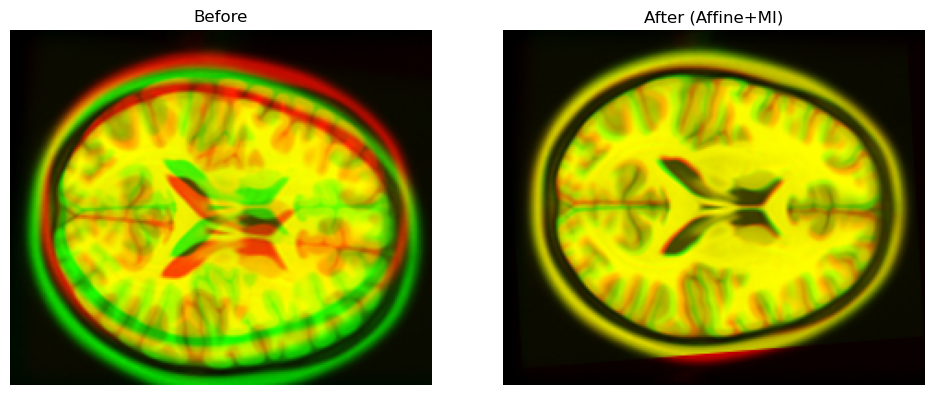

Estimated affine (2D):
 [[ 1.04440503e+00  8.37706585e-02  2.77432630e-04]
 [-6.04397216e-02  1.04636511e+00 -3.19373243e-04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Mean |fixed - moving| before: 0.1976
Mean |fixed - registered| after : 0.0567


In [6]:
import numpy as np, matplotlib.pyplot as plt, nibabel as nib
import templateflow.api as tflow
from skimage import transform
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import AffineTransform2D

# 1) Load MNI template and take a 2D slice
mni_path = tflow.get('MNI152NLin2009cAsym', resolution=1, suffix='T1w', desc=None)
mni_img  = nib.load(mni_path)
mni_data = mni_img.get_fdata(dtype=np.float32)
k        = mni_data.shape[2] // 2
fixed    = mni_data[:, :, k]
fixed    = (fixed - np.percentile(fixed,1)) / (np.percentile(fixed,99)-np.percentile(fixed,1) + 1e-8)
fixed    = np.clip(fixed, 0, 1).astype(np.float32)

# 2) Make a misaligned "moving" slice (known transform)
tform_true = transform.SimilarityTransform(scale=1.05, rotation=np.deg2rad(7.5), translation=(8, -6))
moving = transform.warp(fixed, inverse_map=tform_true.inverse, mode="edge").astype(np.float32)

# 3) DIPY 2D affine registration with MI (coarse -> fine)
level_iters = [10000, 1000, 100]
sigmas      = [3.0,   1.0,  0.0]
factors     = [4,     2,    1]
metric = MutualInformationMetric(nbins=32)  # MI is robust to intensity differences
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)
affine_map = affreg.optimize(static=fixed, moving=moving, transform=AffineTransform2D(), params0=None)
registered = affine_map.transform(moving)

# 4) Visualize and quantify
def overlay(R, G): 
    return np.dstack([R, G, np.zeros_like(R)])

mad_before = np.mean(np.abs(fixed - moving))
mad_after  = np.mean(np.abs(fixed - registered))

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(overlay(fixed, moving));     ax[0].set_title("Before"); ax[0].axis("off")
ax[1].imshow(overlay(fixed, registered)); ax[1].set_title("After (Affine+MI)"); ax[1].axis("off")
plt.tight_layout(); plt.show()

print("Estimated affine (2D):\n", affine_map.affine)
print(f"Mean |fixed - moving| before: {mad_before:.4f}")
print(f"Mean |fixed - registered| after : {mad_after:.4f}")


---



## 🧠 Task 3 – 3D Affine Registration (Subject → MNI Template)

### 🎯 Goal

Register a subject’s 3D T1-weighted image to the **MNI 152 template** using **Mutual Information (MI)** and a **three-stage affine pipeline** (Translation → Rigid → Affine).



### 🪜 Steps

1. **Load the data**

   * Use TemplateFlow to get the MNI 152 T1 template (static image).
   * Load a subject T1 image (moving image) with nibabel.
   * Make both images canonical (RAS+) and convert to float32.

2. **Visual baseline**

   * Resample the subject image to the MNI grid (only for visualization, not registration).
   * Show one axial slice overlay before alignment.

3. **Run affine registration**

   * Define the MI metric (`nbins=32`) and a multiresolution setup (`level_iters`, `sigmas`, `factors`).
   * Optimize in three stages:

     * `TranslationTransform3D()`
     * `RigidTransform3D()`
     * `AffineTransform3D()`
   * Pass `params0=None` and reuse the previous transform as `starting_affine`.

4. **Apply and visualize**

   * Apply the final affine transform once to the moving image.
   * Display red/green overlays of MNI vs. registered subject (before → after).
   * Print the resulting 4 × 4 affine matrix.



### 📤 Deliverables

* Code implementing the four steps above.
* Two overlay images: **before** and **after** registration.
* The printed **4×4 affine matrix** and a short note confirming alignment improvement.




Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


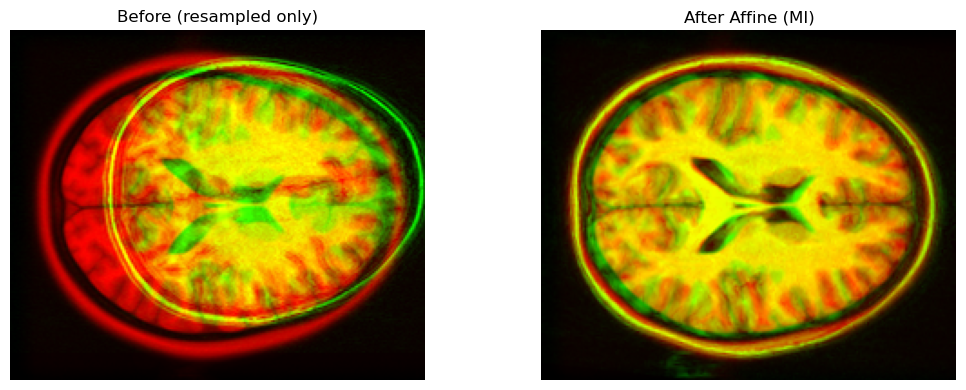

Final affine 4x4 (moving→MNI):
 [[ 8.94329426e-01 -9.92472810e-02  5.58668139e-03 -9.49420861e+00]
 [ 8.98222355e-02  8.93637114e-01 -1.03929107e-01  1.97322858e+01]
 [-1.15247556e-04  1.49856018e-01  7.75875344e-01 -2.98514963e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [ ]:
import numpy as np, nibabel as nib, matplotlib.pyplot as plt, templateflow.api as tflow
from nibabel.processing import resample_from_to
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

# 1) Load static (MNI) and moving (subject)
mni_path = tflow.get('MNI152NLin2009cAsym', resolution=1, suffix='T1w', desc=None)
mni_img  = nib.load(mni_path)
t1_img   = nib.load('sub-10159_T1w.nii')    # make sure path/file exists in your env
mni_img  = nib.as_closest_canonical(mni_img)
t1_img   = nib.as_closest_canonical(t1_img)
static   = mni_img.get_fdata(dtype=np.float32)
moving   = t1_img.get_fdata(dtype=np.float32)

# 2) Quick resample for a visual baseline (not registration)
t1_on_mni = resample_from_to(t1_img, (mni_img.shape, mni_img.affine))
mni_slice = static[:, :, static.shape[2]//2]
t1r_slice = moving[:, :, static.shape[2]//2]

def norm99(x):
    p1, p99 = np.percentile(x, (1, 99))
    return np.clip((x - p1) / (p99 - p1 + 1e-8), 0, 1).astype(np.float32)

overlay_before = np.dstack([norm99(mni_slice), norm99(t1r_slice), np.zeros_like(mni_slice)])

# 3) Affine registration (MI) with multiresolution
metric      = MutualInformationMetric(nbins=32)
level_iters = [10000, 1000, 100]
sigmas      = [3.0,   1.0,  0.0]
factors     = [4,     2,    1]
affreg = AffineRegistration(metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors)

translation = affreg.optimize(
    static, moving, TranslationTransform3D(),
    params0=None,  # <-- required
    static_grid2world=mni_img.affine, moving_grid2world=t1_img.affine
)

rigid = affreg.optimize(
    static, moving, RigidTransform3D(),
    params0=None,  # <-- required
    static_grid2world=mni_img.affine, moving_grid2world=t1_img.affine,
    starting_affine=translation.affine
)

affine = affreg.optimize(
    static, moving, AffineTransform3D(),
    params0=None,  # <-- required
    static_grid2world=mni_img.affine, moving_grid2world=t1_img.affine,
    starting_affine=rigid.affine
)

# 4) Apply once and visualize an axial slice overlay
t1_affined = affine.transform(moving)  # resampled onto the static (MNI) grid
m2 = norm99(t1_affined[:, :, static.shape[2]//2])
s2 = norm99(mni_slice)
overlay_after = np.dstack([s2, m2, np.zeros_like(s2)])

fig, ax = plt.subplots(1, 2, figsize=(11, 4))
ax[0].imshow(overlay_before); ax[0].set_title("Before (resampled only)"); ax[0].axis("off")
ax[1].imshow(overlay_after);  ax[1].set_title("After Affine (MI)");     ax[1].axis("off")
plt.tight_layout(); plt.show()

print("Final affine 4x4 (moving→MNI):\n", affine.affine)



---

## 🧠 Task 4 – Nonlinear (SyN) Refinement after Affine

### 🎯 Goal

Refine a subject T1 → MNI alignment using **Symmetric Diffeomorphic Registration (SyN)** with **local cross-correlation (CC)**, starting from the **affine** result.


### 🪜 Steps

1. **Load data**

   * Fetch MNI152 T1 (static) via TemplateFlow and load the subject T1 (moving).
   * Make both RAS+; cast to `float32`.

2. **Estimate affine (init)**

   * Use `AffineRegistration` with MI and a 3-level pyramid.
   * Run **Translation → Rigid → Affine** (pass `params0=None`; chain via `starting_affine`).
   * Save the final affine as `prealign`.

3. **Run SyN (nonlinear)**

   * Define `CCMetric(3, sigma_diff=2.0, radius=2)`.
   * Create `SymmetricDiffeomorphicRegistration` with `level_iters=[100, 50, 25]`.
   * Call `optimize(...)` with `prealign=affine.affine` to initialize from your affine.

4. **Apply & visualize**

   * Transform the moving image with the SyN mapping.
   * Show overlays on an axial slice: **after affine** vs **after SyN**.


### 📤 Deliverables

* Code for the four steps above.
* Two overlays: **Affine** vs **SyN** (same slice).
* A brief note (2–3 sentences) summarizing the visible improvement from SyN over affine.


Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]
Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


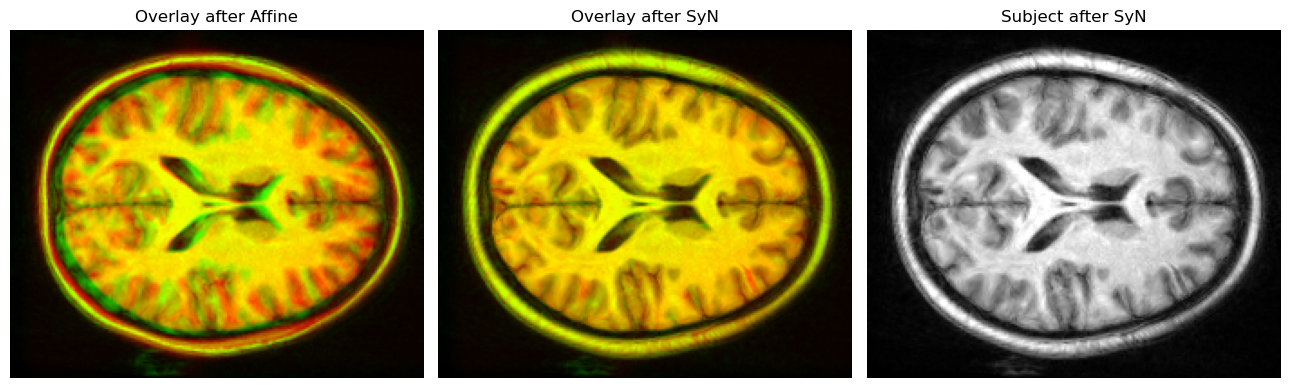

In [1]:
import numpy as np, nibabel as nib, matplotlib.pyplot as plt, templateflow.api as tflow
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import TranslationTransform3D, RigidTransform3D, AffineTransform3D

# --- Re-run (or load) the affine from Task 3 quickly for a complete, single cell example ---
mni_path = tflow.get('MNI152NLin2009cAsym', resolution=1, suffix='T1w', desc=None)
mni_img  = nib.load(mni_path)
t1_img   = nib.load('sub-10159_T1w.nii')   
mni_img  = nib.as_closest_canonical(mni_img)
t1_img   = nib.as_closest_canonical(t1_img)
static   = mni_img.get_fdata(dtype=np.float32)
moving   = t1_img.get_fdata(dtype=np.float32)

metric_mi  = MutualInformationMetric(nbins=32)
affreg     = AffineRegistration(metric=metric_mi,
                                level_iters=[10000, 1000, 100],
                                sigmas=[3, 1, 0],
                                factors=[4, 2, 1])

# --- NOTE: params0=None is REQUIRED here (as a keyword) ---
translation = affreg.optimize(static=static,
                              moving=moving,
                              transform=TranslationTransform3D(),
                              params0=None,
                              static_grid2world=mni_img.affine,
                              moving_grid2world=t1_img.affine)

rigid = affreg.optimize(static=static,
                        moving=moving,
                        transform=RigidTransform3D(),
                        params0=None,
                        static_grid2world=mni_img.affine,
                        moving_grid2world=t1_img.affine,
                        starting_affine=translation.affine)

affine = affreg.optimize(static=static,
                         moving=moving,
                         transform=AffineTransform3D(),
                         params0=None,
                         static_grid2world=mni_img.affine,
                         moving_grid2world=t1_img.affine,
                         starting_affine=rigid.affine)

prealign_affine = affine.affine

# --- SyN with local CC (coarse -> fine) ---
cc_metric = CCMetric(3, sigma_diff=2.0, radius=2)
sdr = SymmetricDiffeomorphicRegistration(cc_metric, level_iters=[100, 50, 25])
mapping = sdr.optimize(static=static,
                       moving=moving,
                       static_grid2world=mni_img.affine,
                       moving_grid2world=t1_img.affine,
                       prealign=prealign_affine)

t1_syn = mapping.transform(moving)

# --- Visualize the same axial slice before/after SyN ---
def norm99(x):
    p1, p99 = np.percentile(x, (1, 99))
    return np.clip((x - p1) / (p99 - p1 + 1e-8), 0, 1).astype(np.float32)

k  = static.shape[2] // 2
s2 = norm99(static[:, :, k])
a2 = norm99(affine.transform(moving)[:, :, k])  # after affine only
y2 = norm99(t1_syn[:, :, k])                    # after SyN

fig, ax = plt.subplots(1, 3, figsize=(13, 4))
ax[0].imshow(np.dstack([s2, a2, np.zeros_like(s2)])); ax[0].set_title("Overlay after Affine"); ax[0].axis("off")
ax[1].imshow(np.dstack([s2, y2, np.zeros_like(s2)])); ax[1].set_title("Overlay after SyN");    ax[1].axis("off")
ax[2].imshow(y2, cmap='gray'); ax[2].set_title("Subject after SyN"); ax[2].axis("off")
plt.tight_layout(); plt.show()




---

## 🧩 **Bonus Task – Full fMRI Preprocessing Pipeline**

### 🎯 **Goal**

Perform all main preprocessing steps on the provided subject’s fMRI data — equivalent to the **CONN Toolbox preprocessing pipeline** — using Python tools (e.g., *NiBabel, Nilearn, Nipype, DIPY, or fMRIPrep* concepts).
You will start from **raw data** and end with **normalized, smoothed fMRI volumes** ready for analysis.

---

### 📁 **Dataset Provided**

Located in:

```
\TASK.DATA\
```

* **Anatomical (T1w)** → `anat/sub-10225_T1w.nii`
* **Functional (BOLD)** → `func/sub-10225_task-stopsignal_bold.nii`

---

### 🧱 **Processing Steps**

1. **Functional Realignment (Motion Correction)**

   * Correct head motion by aligning all fMRI volumes to the first or mean image.
   * Save the realigned images and motion parameter file (6 motion regressors).

2. **Slice-Timing Correction**

   * Correct for differences in slice acquisition timing.
   * Use interpolation so that all slices appear sampled at the same time.
   * Choose the **middle slice** as the reference.

3. **Structural Segmentation and Normalization**

   * Segment the T1 image into GM, WM, and CSF.
   * Normalize the T1 to **MNI space** and save:

     * Normalized T1
     * GM, WM, CSF probability maps
     * Deformation fields or affine matrices

4. **Functional Normalization and Coregisteration**

   * Coregister the functional mean image to the subject’s T1.
   * Apply the same MNI transformation from Step 3 to the functional volumes.
   * Save the normalized functional data (2 mm isotropic voxels).

5. **Functional Smoothing**

   * Apply a Gaussian smoothing kernel (e.g., **8 mm FWHM**) to the normalized data.
   * Save the smoothed functional images.

---

### 🧪 **Deliverables**

Students should submit:

1. A short notebook or script performing the 5 steps above.
2. One example figure for each step (e.g., before/after plots for alignment, normalization, and smoothing).
3. A short paragraph explaining **why each preprocessing step is necessary**.

---

### 💡 **Hint Tools**

You can use:

* `nilearn.image` for resampling, smoothing, and masking
* `nipype.interfaces.spm` or `fmriprep` for a high-level workflow
* `matplotlib` for visualization of slices




In [12]:
"""
BONUS TASK — Full fMRI Preprocessing (Python version of CONN pipeline)

Pipeline Steps:
1. Functional Realignment (Motion Correction)
2. Slice-Timing Correction
3. Structural Segmentation + Normalization to MNI
4. Functional Normalization
5. Functional Smoothing

Tools: NiBabel, TemplateFlow, DIPY, Nilearn, NumPy, scikit-learn
"""

import os, json
import numpy as np
import nibabel as nib
import templateflow.api as tflow
from nibabel.processing import resample_from_to, resample_to_output

# DIPY for registration
from dipy.align.imaffine import AffineRegistration, MutualInformationMetric
from dipy.align.transforms import (
    TranslationTransform3D,
    RigidTransform3D,
    AffineTransform3D
)
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric

# Simple segmentation & smoothing
from sklearn.cluster import KMeans
from nilearn.image import smooth_img

# -----------------------
# Helper: safer TemplateFlow fetch
# -----------------------
def tf_get_one(*args, **kwargs):
    """Ensure TemplateFlow returns exactly one file path."""
    p = tflow.get(*args, **kwargs)
    if isinstance(p, (list, tuple)):
        if len(p) == 0:
            raise FileNotFoundError("TemplateFlow returned no matches.")
        p = p[0]
    return str(p)

# -----------------------
# PATHS & SETTINGS
# -----------------------
SUBJECT_ROOT = r"H:\ML.neuroimaging\teaching\S 9\TASK.DATA"
ANAT_PATH = os.path.join(SUBJECT_ROOT, "anat", "sub-10225_T1w.nii")
FUNC_PATH = os.path.join(SUBJECT_ROOT, "func", "sub-10225_task-stopsignal_bold.nii")
FUNC_JSON = os.path.join(SUBJECT_ROOT, "func", "sub-10225_task-stopsignal_bold.json")
OUT_DIR = os.path.join(SUBJECT_ROOT, "derivatives", "simple_preproc")
os.makedirs(OUT_DIR, exist_ok=True)

# Load JSON metadata (TR, slice timing)
with open(FUNC_JSON, "r") as f:
    meta = json.load(f)
TR = float(meta.get("RepetitionTime", 2.0))
slice_timing = np.array(meta.get("SliceTiming"))
ref_time = float(np.median(slice_timing))

# -----------------------
# LOAD DATA
# -----------------------
anat_img = nib.as_closest_canonical(nib.load(ANAT_PATH))
func_img = nib.as_closest_canonical(nib.load(FUNC_PATH))
anat = anat_img.get_fdata(dtype=np.float32)
func = func_img.get_fdata(dtype=np.float32)
print("Anat shape:", anat.shape, "Func shape:", func.shape)

# -----------------------
# 1) MOTION CORRECTION
# -----------------------
print("\n[1/5] Motion Correction (Rigid per volume)")
metric = MutualInformationMetric(nbins=32)
affreg = AffineRegistration(metric=metric, level_iters=[1000, 100, 10],
                            sigmas=[3, 1, 0], factors=[4, 2, 1])

rigid_tfm = RigidTransform3D()
ref_vol = func[..., 0]
ref_aff = func_img.affine
T = func.shape[-1]
mc_func = np.zeros_like(func)
mc_func[..., 0] = ref_vol
motion_affs = [np.eye(4)]

for t in range(1, T):
    moving = func[..., t]
    opt = affreg.optimize(static=ref_vol, moving=moving,
                          transform=rigid_tfm, params0=None,
                          static_grid2world=ref_aff, moving_grid2world=ref_aff)
    motion_affs.append(opt.affine)
    mc_func[..., t] = opt.transform(moving)

nib.save(nib.Nifti1Image(mc_func, ref_aff, func_img.header),
         os.path.join(OUT_DIR, "func_mc.nii.gz"))
np.savetxt(os.path.join(OUT_DIR, "motion_affines.tsv"),
           np.stack(motion_affs).reshape(T, -1), delimiter="\t")
print("  → Saved func_mc.nii.gz and motion_affines.tsv")

# -----------------------
# 2) SLICE-TIMING CORRECTION
# -----------------------
print("\n[2/5] Slice-Timing Correction (linear interpolation)")
X, Y, Z, T = mc_func.shape
time = np.arange(T) * TR
stc_func = np.zeros_like(mc_func)

for z in range(Z):
    dt = ref_time - slice_timing[z]
    shifted = np.clip(time + dt, time[0], time[-1])
    data = mc_func[:, :, z, :].reshape(-1, T)
    for i in range(data.shape[0]):
        data[i] = np.interp(shifted, time, data[i])
    stc_func[:, :, z, :] = data.reshape(X, Y, T)

stc_img = nib.Nifti1Image(stc_func, ref_aff, func_img.header)
nib.save(stc_img, os.path.join(OUT_DIR, "func_mc_stc.nii.gz"))
print("  → Saved func_mc_stc.nii.gz")

# -----------------------
# 3) T1 SEGMENTATION + NORMALIZATION
# -----------------------
print("\n[3/5] T1 segmentation (k-means) and normalization to MNI")
p1, p99 = np.percentile(anat, (1, 99))
anat_n = np.clip((anat - p1) / (p99 - p1 + 1e-8), 0, 1)
kmeans = KMeans(n_clusters=3, n_init=5, random_state=0).fit(anat_n.reshape(-1, 1))
lbls = kmeans.labels_.reshape(anat.shape)
means = kmeans.cluster_centers_.ravel()
order = np.argsort(means)
csf, gm, wm = [(lbls == order[i]).astype(np.float32) for i in range(3)]
nib.save(nib.Nifti1Image(gm, anat_img.affine), os.path.join(OUT_DIR, "anat_gm.nii.gz"))
nib.save(nib.Nifti1Image(wm, anat_img.affine), os.path.join(OUT_DIR, "anat_wm.nii.gz"))
nib.save(nib.Nifti1Image(csf, anat_img.affine), os.path.join(OUT_DIR, "anat_csf.nii.gz"))

# Load MNI template (force single path)
mni_path = tf_get_one("MNI152NLin2009cAsym", resolution=1, suffix="T1w", extension="nii.gz")
mni_img = nib.as_closest_canonical(nib.load(mni_path))
mni = mni_img.get_fdata(dtype=np.float32)

# Affine + SyN normalization
metric_mi = MutualInformationMetric(nbins=32)
affreg = AffineRegistration(metric=metric_mi,
                            level_iters=[10000, 1000, 100],
                            sigmas=[3, 1, 0], factors=[4, 2, 1])

trans = affreg.optimize(static=mni, moving=anat,
                        transform=TranslationTransform3D(), params0=None,
                        static_grid2world=mni_img.affine, moving_grid2world=anat_img.affine)
rigid = affreg.optimize(static=mni, moving=anat,
                        transform=RigidTransform3D(), params0=None,
                        static_grid2world=mni_img.affine, moving_grid2world=anat_img.affine,
                        starting_affine=trans.affine)
affine = affreg.optimize(static=mni, moving=anat,
                         transform=AffineTransform3D(), params0=None,
                         static_grid2world=mni_img.affine, moving_grid2world=anat_img.affine,
                         starting_affine=rigid.affine)
prealign = affine.affine

cc_metric = CCMetric(3, sigma_diff=2.0, radius=2)
sdr = SymmetricDiffeomorphicRegistration(cc_metric, level_iters=[100, 50, 25])
t1_map = sdr.optimize(static=mni, moving=anat,
                      static_grid2world=mni_img.affine,
                      moving_grid2world=anat_img.affine,
                      prealign=prealign)

anat_mni = t1_map.transform(anat)
nib.save(nib.Nifti1Image(anat_mni, mni_img.affine), os.path.join(OUT_DIR, "anat_in_MNI.nii.gz"))
print("  → Saved anat_in_MNI.nii.gz")

# -----------------------
# 4) FUNCTIONAL NORMALIZATION
# -----------------------
print("\n[4/5] Functional normalization (rigid → T1, then warp to MNI)")
mean_bold = stc_func.mean(axis=-1)
bold2t1 = affreg.optimize(static=anat, moving=mean_bold,
                          transform=RigidTransform3D(), params0=None,
                          static_grid2world=anat_img.affine,
                          moving_grid2world=func_img.affine)
target_img = resample_to_output(mni_img, voxel_sizes=(2, 2, 2))
target_shape, target_aff = target_img.shape, target_img.affine
norm_func = np.zeros(target_shape + (T,), dtype=np.float32)

for t in range(T):
    vol_t = stc_func[..., t]
    vol_in_t1 = bold2t1.transform(vol_t)
    vol_in_mni = t1_map.transform(vol_in_t1)
    vol_rs = resample_from_to(nib.Nifti1Image(vol_in_mni, mni_img.affine),
                              (target_shape, target_aff))
    norm_func[..., t] = vol_rs.get_fdata(dtype=np.float32)

nib.save(nib.Nifti1Image(norm_func, target_aff),
         os.path.join(OUT_DIR, "func_norm_2mm.nii.gz"))
print("  → Saved func_norm_2mm.nii.gz")

# -----------------------
# 5) FUNCTIONAL SMOOTHING
# -----------------------
print("\n[5/5] Functional smoothing (8mm FWHM)")
smoothed = smooth_img(os.path.join(OUT_DIR, "func_norm_2mm.nii.gz"), fwhm=8.0)
nib.save(smoothed, os.path.join(OUT_DIR, "func_norm_2mm_smooth8.nii.gz"))
print("  → Saved func_norm_2mm_smooth8.nii.gz")

print("\nDONE ✅  All outputs saved in:", OUT_DIR)


Anat shape: (176, 256, 256) Func shape: (64, 64, 34, 184)

[1/5] Motion Correction (Rigid per volume)
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [max iter: 100]
Optimizing level 0 [max iter: 10]
Optimizing level 2 [max iter: 1000]
Optimizing level 1 [ma